# **Research: Titan's Adaptive Memory Architecture for Non-Stationary Financial Forecasting**
Authors: - Youness Khayour - Hamza Zouak

## **I. Introduction**

### **1.Research Problem**

Financial time series are non-stationary: their statistical properties (mean, variance, correlations) change over time due to regime shifts in stable vs volatile markets.  

Although Transformers models have attention, they rely on fixed-length attention windows and lack memory, making them poorly suited to capture long-term, regime-dependent dynamics.

Google latest Research’s Titan architecture introduces neural memory module to address the limitation of extremely volatile time-series data by introducing:
- Long-horizon information retention (over 1M token)
- Selective memory updates (Through gating mechanism like LSTM)
- Adaptive forgetting under distribution shifts (Through Surprise-driven gradients and adaptive weight decay)

> **However, the practical behavior of Titan-style memory—especially under limited data and financial non-stationarity remains underexplored.**





### **2.Research Objectives**
This notebook will evaluate whether **Titan-MAG (Memory-As-Gate)** improves learning under financial non-stationarity and whether it outperforms the previous state-of-the-art architecture "Transformers".

the study will:

- Implement Titan's Neural Memory Behavior, Gating Dynamics, and Forgetting Mechanisms

- Preprocess the volatile financial timeseries data and prepare it for evaluation

- Train both Titan vs Transform & Compare performance across:
  - Stable vs volatile regimes
  - Different feature sets

- Identify failure modes: memorization, instability, or overfitting.

- Memory ablation Study (gating, forgetting, surprise-driven updates)


## **2. Environment Setup**

In [ ]:
# libraries

!pip install titans-pytorch --quiet
!pip install einops --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.8/96.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.0/450.0 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.6/100.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.5 MB/s eta 0:00:00


In [ ]:
!pip install tensordict --quiet
!pip install assoc_scan --quiet
!pip install titans_pytorch.memory_models --quiet
!pip install git+https://github.com/lucidrains/tensordict.git --quiet
!pip install einx --quiet

ERROR: Could not find a version that satisfies the requirement titans_pytorch.memory_models (from versions: none)
ERROR: No matching distribution found for titans_pytorch.memory_models
  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet https://github.com/lucidrains/tensordict.git /tmp/pip-req-build-c6etrhya did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet https://github.com/lucidrains/tensordict.git /tmp/pip-req-build-c6etrhya did not run successfully.
│ exit code: 128
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
# Libraries imports

import math
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import pickle
import matplotlib.pyplot as plt

from __future__ import annotations
from typing import Callable

import math
from functools import partial
from itertools import zip_longest
from collections import namedtuple

import torch
from torch import nn, stack, cat, is_tensor, tensor, Tensor
import torch.nn.functional as F
from torch.nn import Linear, Module, Parameter, ParameterList, ParameterDict
from torch.func import functional_call, vmap, grad
from torch.utils._pytree import tree_map, tree_flatten, tree_unflatten

from tensordict import TensorDict

from assoc_scan import AssocScan

from titans_pytorch.memory_models import(
    MemoryMLP,
    ResidualNorm
)

import einx
from einops import einsum, rearrange, repeat, reduce, pack, unpack
from einops.layers.torch import Rearrange, Reduce

"""
ein notation:
b - batch
h - heads
bh - batch and heads
n - sequence
d - feature dimension
c - intra-chunk
w - num memory network weight parameters
o - momentum orders
u - key / value updates - allowing a token to emit multiple key / values
"""

'\nein notation:\nb - batch\nh - heads\nbh - batch and heads\nn - sequence\nd - feature dimension\nc - intra-chunk\nw - num memory network weight parameters\no - momentum orders\nu - key / value updates - allowing a token to emit multiple key / values\n'

## **III. TITAN ARCHITECTURE IMPLEMENTATION**

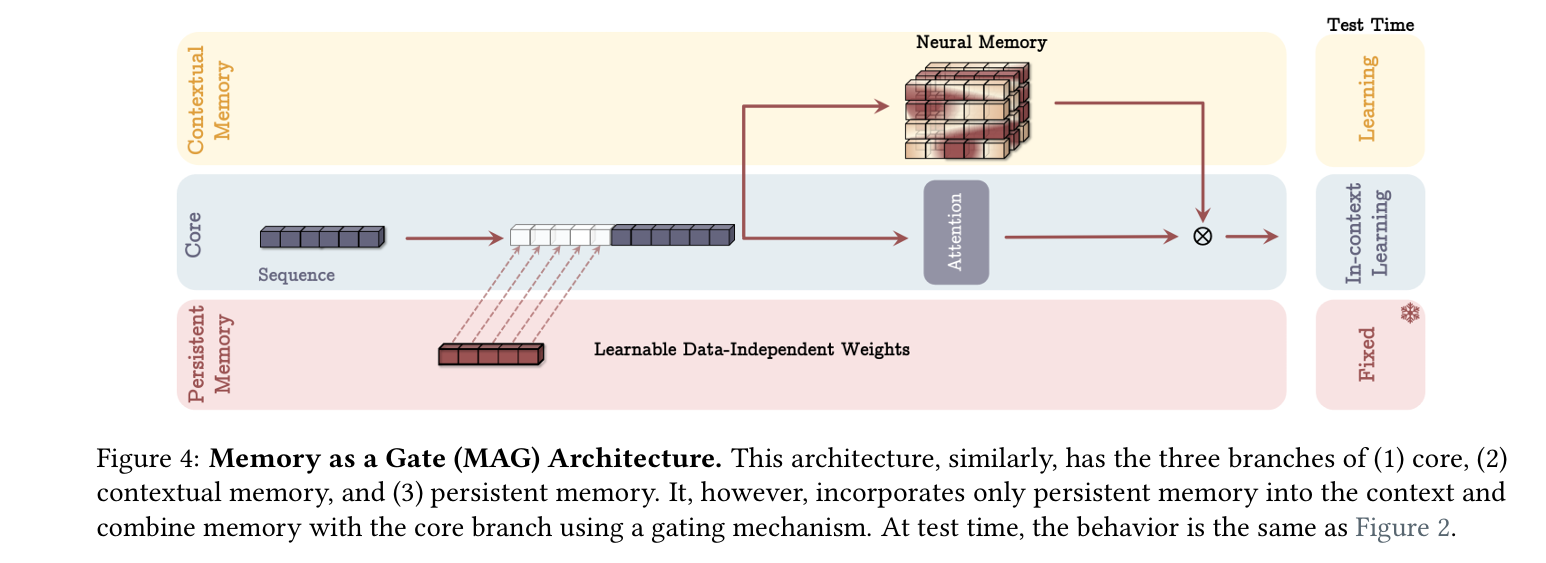

#### **1.NEURAL MEMORY MODULE - Contextual Memory**

> **What's this?**  

  **A suprise gradient-based Neural Memory implementation**, The titan's main feature highlighted in Google's paper. The memory is represented as the weights of a small neural network, rather than a fixed key–value cache. This follows the same core philosophy as **Titan / Test-Time Training (TTT)**: learning and adapting memory online.

  This code is Adapted from Lucidrains’ `titans_pytorch` implementation

>**How we used it in our research**

  - Integrated it as the **Contextual memory** inside a Titan's backbone.
  - Chnaged its internal functions **to store and retrieve regime-sensitive information** from financial time series (FINSPID).
  - Treated **memory updates as learning signals** driven by prediction surprise rather than static attention.
  - Patched and extended it to support:
    - **Regime-Aware Adaptive forgetting (weight decay)** for non-stationary.
    - **Surprise-driven memory updates**
    - **Gating mechanisms** to control reliance on memory vs core Transformer output
  - Logged memory behavior (update rate, gate activation) to **compare empirical dynamics against Titan’s claims**.

> **Role in our experiments**
  This module enabled us to move beyond a static Transformer baseline and **explicitly study online adaptation, forgetting, and memory control**, which are central to Titan-style architectures under regime shifts.


In [ ]:
LinearNoBias = partial(Linear, bias = False)

# neural mem state related

NeuralMemState = namedtuple('NeuralMemState', [
    'seq_index',
    'weights',
    'cache_store_segment',
    'states',
    'updates',
])

def mem_state_detach(
    state: NeuralMemState
):
    assert isinstance(state, NeuralMemState)
    state = tree_map(lambda t: t.detach() if is_tensor(t) else t, tuple(state))
    return NeuralMemState(*state)

# functions

def exists(v):
    return v is not None

def default(*args):
    for arg in args:
        if exists(arg):
            return arg
    return None

def identity(t):
    return t

def xnor(x, y):
    return not (x ^ y)

def divisible_by(num, den):
    return (num % den) == 0

def safe_cat(inputs, dim = -2):
    inputs = tuple(filter(exists, inputs))

    if len(inputs) == 0:
        return None
    elif len(inputs) == 1:
        return inputs[0]

    return cat(inputs, dim = dim)

def is_empty_tensor(t):
    return t.numel() == 0

def dict_get_value_shapes(td):
    return [v.shape for k, v in td.items()]

def rearrange_dict_values(td, pattern, **kwargs):
    return td.apply(lambda t: rearrange(t, pattern, **kwargs))

def repeat_dict_values(td, pattern, **kwargs):
    return td.apply(lambda t: repeat(t, pattern, **kwargs))

def pair(v):
    return (v, v) if not isinstance(v, tuple) else v

def round_down_multiple(seq, mult):
    return seq // mult * mult

def round_up_multiple(seq, mult):
    return math.ceil(seq / mult) * mult

def pad_at_dim(t, pad, dim = -1, value = 0.):
    dims_from_right = (- dim - 1) if dim < 0 else (t.ndim - dim - 1)
    zeros = ((0, 0) * dims_from_right)
    return F.pad(t, (*zeros, *pad), value = value)

def pack_one_with_inverse(t, pattern):
    packed, packed_shape = pack([t], pattern)

    def inverse(out, inv_pattern = None):
        inv_pattern = default(inv_pattern, pattern)
        return unpack(out, packed_shape, inv_pattern)[0]

    return packed, inverse

def Sequential(*modules):
    modules = [*filter(exists, modules)]

    if len(modules) == 0:
        return nn.Identity()

    if len(modules) == 1:
        return modules[0]

    return nn.Sequential(*modules)

# softclamping gradients

def softclamp_max(t, max_value):
    half_max_value = max_value / 2
    return ((t / half_max_value).tanh() * half_max_value) + half_max_value

def softclamp_grad_norm(t, max_value):
    if is_empty_tensor(t):
        return t

    t, inverse = pack_one_with_inverse(t, 'bn *')

    norm = t.norm(dim = -1, keepdim = True)
    clamped_norm = softclamp_max(norm, max_value)

    t = t * (clamped_norm / norm)
    return inverse(t)

# spectral norming the surprise update w/ newton schulz matrix iter
# Keller Jordan et al. from OSS w/ nanogpt, now being used for two works, Atlas and 'TTT done right'

def newtonschulz5(
    t,
    steps = 5,
    eps = 1e-7,
    coefs = (3.4445, -4.7750, 2.0315)
):
    if t.ndim <= 3:
        return t

    shape = t.shape
    should_transpose = shape[-2] > shape[-1]

    if should_transpose:
        t = t.transpose(-1, -2)

    t, inv_pack = pack_one_with_inverse(t, '* i j')
    t = t / t.norm(dim = (-1, -2), keepdim = True).clamp(min = eps)

    a, b, c = coefs

    for _ in range(steps):
        A = t @ t.transpose(-1, -2)
        B = b * A + c * A @ A
        t = a * t + B @ t

    if should_transpose:
        t = t.transpose(-1, -2)

    return inv_pack(t)

# multi head rmsnorm

class MultiheadRMSNorm(Module):
    def __init__(self, dim, heads):
        super().__init__()
        self.rmsnorm = nn.RMSNorm(dim, elementwise_affine = False)
        self.gamma = Parameter(torch.zeros(heads, 1, dim))

    def forward(self, x):
        return self.rmsnorm(x) * (self.gamma + 1.)

# chunk pooling

class AveragePool(Module):
    def __init__(
        self,
        chunk_size
    ):
        super().__init__()
        self.chunk_size = chunk_size

    def forward(
        self,
        x,
        chunk_size = None
    ):
        chunk_size = default(chunk_size, self.chunk_size)
        return reduce(x, 'b (n c) d -> b n d', 'mean', c = chunk_size)

class AttentionPool(Module):
    def __init__(
        self,
        dim,
        chunk_size
    ):
        """
        taken from Enformer https://www.nature.com/articles/s41592-021-01252-x , in turn taken from somewhere else
        """
        super().__init__()
        self.chunk_size = chunk_size
        self.to_attn_logits = nn.Linear(dim, dim)

        # default to average pool

        nn.init.zeros_(self.to_attn_logits.weight)
        nn.init.zeros_(self.to_attn_logits.bias)

    def forward(
        self,
        x,
        chunk_size = None
    ):
        chunk_size = default(chunk_size, self.chunk_size)

        x = rearrange(x, 'b (n c) d -> b n c d', c = chunk_size)

        attn_logits = self.to_attn_logits(x)

        attn = attn_logits.softmax(dim = -2)

        return reduce(x * attn, 'b n c d -> b n d', 'sum')

# main neural memory

def default_adaptive_step_transform(adaptive_step, max_lr = 1e-2):
    return adaptive_step.sigmoid() * max_lr

def default_loss_fn(pred, target):
    return (pred - target).pow(2).mean(dim = -1)

class NeuralMemoryRegime(Module):
    def __init__(
        self,
        dim,
        chunk_size: int | tuple[int, int] = 1,
        batch_size = None,
        dim_head = None,
        heads = 1,
        model: Module | None = None,
        store_memory_loss_fn: Callable = default_loss_fn,
        adaptive_step_transform: Callable | None = None,
        default_step_transform_max_lr = 1.,
        per_parameter_lr_modulation = False, # allow outer network to control learning rate per weight matrix of memory network
        max_mem_layer_modulation = 1., # max of 10.
        per_head_learned_parameters = True,
        attn_pool_chunks = False,
        momentum = True,
        momentum_order = 1,
        learned_momentum_combine = False,
        learned_combine_include_zeroth = False,
        num_kv_per_token = 1, # whether a single token can do multiple updates to the memory model
        qkv_receives_diff_views = False, # to address an issue raised by a phd student (who will be credited if experiments are green). basically the issue raised is that the memory MLP is only learning Wk @ Wv linear mapping and that may not be expressive enough. we will use hyper connections to allow the network to choose different previous layer inputs as keys / values and see if that does anything
        pre_rmsnorm = True,
        post_rmsnorm = False,
        qk_rmsnorm = False,
        max_grad_norm: float | None = None,
        use_accelerated_scan = False,
        activation: Module | None = None,
        init_adaptive_step_bias = None,
        init_momentum_bias = None,
        init_decay_bias = None,
        accept_weight_residual = False,
        spectral_norm_surprises = False,
        gated_transition = False,
        mem_model_norm_add_residual = True, # by default, layernorm output and add residual as proposed in TTT paper, but could be removed
        default_model_kwargs: dict = dict(
            depth = 2,
            expansion_factor = 4.
        )
    ):
        super().__init__()
        dim_head = default(dim_head, dim)
        assert not (heads == 1 and dim_head != dim)

        self.retrieve_chunk_size, self.store_chunk_size = pair(chunk_size)

        # batch size

        if exists(batch_size):
            assert divisible_by(batch_size, self.store_chunk_size)

        self.batch_size = batch_size

        # associative scan

        self.assoc_scan = AssocScan(use_accelerated = use_accelerated_scan)

        # key values receiving different views

        self.qkv_receives_diff_views = qkv_receives_diff_views

        # norms

        self.retrieve_norm = nn.RMSNorm(dim) if pre_rmsnorm else nn.Identity()
        self.store_norm = nn.RMSNorm(dim) if pre_rmsnorm else nn.Identity()

        self.multihead_rmsnorm = MultiheadRMSNorm(dim_head, heads) if post_rmsnorm else nn.Identity()

        self.q_norm = MultiheadRMSNorm(dim_head, heads) if qk_rmsnorm else nn.Identity()
        self.k_norm = MultiheadRMSNorm(dim_head, heads) if qk_rmsnorm else nn.Identity()

        # maybe multi-headed

        dim_inner = dim_head * heads

        self.heads = heads

        self.split_heads = Rearrange('b n (h d) -> b h n d', h = heads)
        self.split_kv_heads = Rearrange('b n (h u d) -> b h (n u) d', h = heads, u = num_kv_per_token)

        self.merge_heads = Rearrange('b h n d -> b n (h d)')
        self.combine_heads = LinearNoBias(dim_inner, dim) if heads > 1 else nn.Identity()

        self.retrieve_gate = Sequential(
            LinearNoBias(dim, heads),
            Rearrange('b n h -> b h n 1'),
            nn.Sigmoid()
        ) if heads > 1 else None

        # memory model

        if not exists(model):
            model = MemoryMLP(dim_head, **default_model_kwargs)

        # validate memory model

        assert not exists(next(model.buffers(), None)), 'model cannot have buffers for now'

        test_shape = (3, 2, dim_head)

        with torch.no_grad():
            try:
                test_input = torch.randn(test_shape)
                mem_model_output = model(test_input)
            except:
                raise RuntimeError(f'memory model unable to accept a tensor of shape {test_shape}')

            assert mem_model_output.shape == test_shape, 'output of memory model needs to be same shape as input'

        # the memory is the weights of the model

        if mem_model_norm_add_residual:
            model = ResidualNorm(dim = dim_head, model = model)

        self.memory_model = model

        mem_model_params = dict(model.named_parameters())

        self.num_memory_parameter_tensors = len(mem_model_params)

        self.memory_model_parameter_names = [*mem_model_params.keys()]

        memory_model_parameters = [*mem_model_params.values()]

        if per_head_learned_parameters:
            memory_model_parameters = [repeat(p, '... -> h ...', h = heads) for p in memory_model_parameters]

        self.init_weight_shape = [p.shape for p in memory_model_parameters]

        self.memory_model_parameters = ParameterList(memory_model_parameters)
        self.per_head_learned_parameters = per_head_learned_parameters

        # the chunk size within the paper where adaptive step, momentum, weight decay are shared

        self.chunk_size = chunk_size

        # prepare function for per sample gradients from model above, using torch.func

        def forward_and_loss(params, inputs, loss_weights, target):
            pred = functional_call(self.memory_model, params, inputs)
            loss = self.store_memory_loss_fn(pred, target) # simple mse loss in paper - eq (12) - |M(k) - v|²
            weighted_loss = loss * loss_weights
            return weighted_loss.sum(), loss

        # two functions

        grad_fn = grad(forward_and_loss, has_aux = True)

        self.per_sample_grad_fn = vmap(grad_fn, in_dims = (0, 0, 0, 0))

        # queries for retrieving from the model

        self.to_queries = Sequential(LinearNoBias(dim, dim_inner), activation)

        # keys and values for storing to the model

        assert num_kv_per_token > 0

        self.to_keys = Sequential(
            LinearNoBias(dim, dim_inner * num_kv_per_token),
            activation,
        )

        self.to_values = Sequential(
            LinearNoBias(dim, dim_inner * num_kv_per_token),
            activation,
        )

        self.store_memory_loss_fn = store_memory_loss_fn

        self.num_kv_per_token = num_kv_per_token

        # `chunk_size` refers to chunk size used for storing to memory model weights

        chunk_size = self.store_chunk_size

        # whether to use averaging of chunks, or attention pooling

        assert not (attn_pool_chunks and chunk_size == 1), '`attn_pool_chunks` cannot be set to True if `chunk_size` is set to 1'

        if not attn_pool_chunks:
            self.reduce_to_chunk_rep = AveragePool(chunk_size = chunk_size)
        else:
            self.reduce_to_chunk_rep = AttentionPool(dim, chunk_size = chunk_size)

        # learned adaptive learning rate

        self.to_adaptive_step = Sequential(
            nn.Linear(dim, heads * num_kv_per_token),
            Rearrange('b n (h u) -> (b h) (n u)', u = num_kv_per_token)
        )

        if not exists(adaptive_step_transform):
            adaptive_step_transform = partial(default_adaptive_step_transform, max_lr = default_step_transform_max_lr)

        self.adaptive_step_transform = adaptive_step_transform

        # momentum related

        self.to_momentum = Sequential(
            nn.Linear(dim, heads * momentum_order),
            Rearrange('b n (h o) -> o (b h) n 1', o = momentum_order)
        ) if momentum else None

        self.momentum_order = momentum_order
        self.to_learned_momentum_combine = None

        if learned_momentum_combine:
            assert momentum
            assert momentum_order > 1, 'only second order momentum allowed for now, but may allow learned combination of zeroth'

            if learned_combine_include_zeroth:
                momentum_order += 1

            self.to_learned_momentum_combine = Sequential(
                nn.Linear(dim, heads * momentum_order),
                Rearrange('b n (h o) -> o (b h) n', h = heads),
                nn.Softmax(dim = 0),
            )

            self.learned_combine_include_zeroth = learned_combine_include_zeroth

        # per layer learning rate modulation

        self.to_layer_modulation = Sequential(
            nn.Linear(dim, heads * self.num_memory_parameter_tensors),
            Rearrange('b n (h w) -> w (b h) n', h = heads),
            nn.Sigmoid()
        ) if per_parameter_lr_modulation else None

        self.max_mem_layer_modulation = max_mem_layer_modulation

        # learned weight residual

        self.to_learned_weight_residual_mix = Sequential(
            nn.Linear(dim, heads),
            Rearrange('b n h -> b h n'),
            nn.Sigmoid()
        ) if accept_weight_residual else None

        # allow for softclamp the gradient norms for storing memories

        self.max_grad_norm = max_grad_norm

        # spectral norming the surprises before update, a la Muon from Jordan et al.

        self.spectral_norm_surprises = spectral_norm_surprises

        # weight decay factor

        self.to_decay_factor = Sequential(
            nn.Linear(dim, heads),
            Rearrange('b n h -> (b h) n 1')
        )

        # learned transition, as seeing instability when decreasing neural mem batch size
        # perhaps it can slowly learn to adjust from early residual to fully transitioning to new weights every batch size

        self.transition_gate = nn.Parameter(tensor(-5.)) if gated_transition else None

        # inits

        if exists(init_adaptive_step_bias):
            linear = self.to_adaptive_step[0]
            nn.init.zeros_(linear.weight)
            nn.init.constant_(linear.bias, init_adaptive_step_bias)

        if exists(init_momentum_bias):
            linear = self.to_momentum[0]
            nn.init.zeros_(linear.weight)
            nn.init.constant_(linear.bias, init_momentum_bias)

        if exists(init_decay_bias):
            linear = self.to_decay_factor[0]
            nn.init.zeros_(linear.weight)
            nn.init.constant_(linear.bias, init_decay_bias)

        # maybe use accelerated scan

        self.use_accelerated_scan = use_accelerated_scan

        self.register_buffer('zero', torch.tensor(0.), persistent = False)

    @property
    def memory_model_parameter_dict(self):
        return TensorDict(dict(zip(self.memory_model_parameter_names, self.memory_model_parameters)))

    def init_weights(
        self,
        batch,
    ):
        if self.per_head_learned_parameters:
            weights = repeat_dict_values(self.memory_model_parameter_dict, 'h ... -> (b h) ...', b = batch)
        else:
            weights = repeat_dict_values(self.memory_model_parameter_dict, '... -> bh ...', bh = batch * self.heads)

        return weights

    def init_momentum(
        self,
        batch,
    ):
        zeros = self.memory_model_parameter_dict.clone().zero_()

        if self.per_head_learned_parameters:
            zeros = repeat_dict_values(zeros, 'h ... -> o (b h) ...', b = batch, o = self.momentum_order)
        else:
            zeros = repeat_dict_values(zeros, '... -> o bh ...', bh = batch * self.heads, o = self.momentum_order)

        return zeros

    def store_memories(
          self,
          seq,
          weights: dict[str, Tensor] | None = None,
          past_state: tuple[dict[str, Tensor], dict[str, Tensor]] | None = None,
          seq_index = 0,
          prev_weights = None,
          mask: Tensor | None = None,
          return_surprises = True,
          forget_gate: Tensor | None = None   # our adaptive forgetting
      ):

        if self.qkv_receives_diff_views:
            _, batch, seq_len = seq.shape[:3]
        else:
            batch, seq_len = seq.shape[:2]

        # shapes and variables

        heads, chunk_size, num_updates = self.heads, self.store_chunk_size, self.num_kv_per_token

        # curtail sequence by multiple of the chunk size
        # only a complete chunk of the sequence provides the memory for the next chunk

        round_down_seq_len = round_down_multiple(seq_len, chunk_size)
        num_chunks = round_down_seq_len // chunk_size

        seq, remainder = seq[..., :round_down_seq_len, :], seq[..., round_down_seq_len:, :]

        next_seq_len_index = seq_index + round_down_seq_len

        # init weights if needed
        # weights of the memory network

        if not exists(weights):
            weights = self.init_weights(batch)

        weights = TensorDict(weights)

        # allow for neural memory of a previous layer to influence surprise of current layer

        weights_for_surprise = repeat_dict_values(weights, 'b ... -> b n ...', n = num_chunks)

        # initial norm

        seq = self.store_norm(seq)

        # handle keys and values coming from different sequences from hyper connection

        values_seq = seq

        if self.qkv_receives_diff_views:
            seq, values_seq = seq

        # derive learned hparams for optimization of memory network

        adaptive_lr = self.to_adaptive_step(seq)
        adaptive_lr = self.adaptive_step_transform(adaptive_lr)

        chunked_seq = self.reduce_to_chunk_rep(seq, chunk_size = chunk_size)

        decay_factor = self.to_decay_factor(chunked_seq).sigmoid()

        # ---------------------------
        # Regime-aware adaptive forgetting
        # ---------------------------
        if exists(forget_gate):
            # forget_gate: [B, 1] or [B, n, 1]
            if forget_gate.ndim == 2:
                forget_gate = forget_gate.unsqueeze(1)

            # expand to heads
            forget_gate = repeat(
                forget_gate,
                'b n 1 -> (b h) n 1',
                h = heads
            )

            # stronger forgetting when forget_gate → 1
            decay_factor = 1. - (1. - decay_factor) * (1. - forget_gate)

        need_layer_lr_mod = exists(self.to_layer_modulation) and num_chunks > 0
        has_momentum = exists(self.to_momentum)

        if has_momentum:
            adaptive_momentum = self.to_momentum(chunked_seq).sigmoid()

            learned_combine = exists(self.to_learned_momentum_combine)

            if learned_combine:
                combine_momentums = self.to_learned_momentum_combine(chunked_seq)

        if need_layer_lr_mod:
            layer_lr_mod = self.to_layer_modulation(chunked_seq) * self.max_mem_layer_modulation

        # keys and values

        keys = self.to_keys(seq)
        values = self.to_values(values_seq)

        # maybe multi head

        keys, values = map(self.split_kv_heads, (keys, values))

        # maybe keys rmsnorm

        keys = self.k_norm(keys)

        # take care of chunking

        keys, values = tuple(rearrange(t, 'b h (n c u) d -> (b h n) (c u) d', c = chunk_size, u = num_updates) for t in (keys, values))

        # adaptive lr

        adaptive_lr = rearrange(adaptive_lr, 'b (n c u) -> (b n) (c u)', c = chunk_size, u = num_updates)

        # optionally a storing memories mask can be passed in. if False, will set the learning rate to 0. for those positions

        if exists(mask):
            mask = mask[..., :round_down_seq_len]
            mask = repeat(mask, 'b (n c) -> (b h n) (c u)', h = heads, u = num_updates, c = chunk_size)

            adaptive_lr = torch.where(mask, adaptive_lr, 0.)

        # maybe add previous layer weight

        assert xnor(exists(self.to_learned_weight_residual_mix), exists(prev_weights))

        if exists(prev_weights):

            start_index = math.ceil(seq_index / chunk_size)
            end_index = start_index + num_chunks

            prev_weights = prev_weights.apply(lambda t: t[:, start_index:end_index])

            if exists(self.to_learned_weight_residual_mix) and num_chunks > 0:
                mix = self.to_learned_weight_residual_mix(chunked_seq)
                mix = rearrange(mix, 'b h n -> (b h) n')
                prev_weights = prev_weights.apply(lambda t: einx.multiply('bh n, bh n ... -> bh n ...', mix, t))

            weights_for_surprise = weights_for_surprise + prev_weights

        # flatten batch and time if surprise depends on previous layer memory model

        weights_for_surprise = rearrange_dict_values(weights_for_surprise, 'b n ... -> (b n) ...')

        # get grads and extra auxiliary loss (for backwarding through qkv projection in base neural memory module)

        grads, unweighted_mem_model_loss = self.per_sample_grad_fn(dict(weights_for_surprise), keys, adaptive_lr, values)

        grads = TensorDict(grads)

        # surprises

        adaptive_lr = rearrange(adaptive_lr, '(b h n) c -> b h (n c)', b = batch, h = heads)
        unweighted_mem_model_loss = rearrange(unweighted_mem_model_loss, '(b h n) c -> b h (n c)', b = batch, h = heads)

        # maybe softclamp grad norm

        if exists(self.max_grad_norm):
            grads = grads.apply(lambda t: softclamp_grad_norm(t, self.max_grad_norm))

        # restore batch and sequence dimension

        grads = rearrange_dict_values(grads, '(b n) ... -> b n ...', b = batch * heads)

        # maybe per layer modulation

        if need_layer_lr_mod:
            grads = TensorDict({name: einx.multiply('b h, b h ... -> b h ...', layer_lr_mod, t) for layer_lr_mod, (name, t) in zip(layer_lr_mod, grads.items())})

        # negative gradients, adaptive lr already applied as loss weight

        surprises = grads.mul(-1)

        # past states

        if not exists(past_state):
            # minibatch_init_weight corresponds to W0 in figure 7 of TTT paper

            minibatch_init_weight = weights
            init_momentum = self.init_momentum(batch)

            past_state = (minibatch_init_weight, init_momentum)

        past_last_update, past_last_momentum = past_state

        # early return if sequence length less than chunk size

        if num_chunks == 0:
            updates = rearrange_dict_values(weights, 'bh ... -> bh 1 ...')
            next_store_state = NeuralMemState(next_seq_len_index, weights, remainder, past_state, updates)

            output = (updates, next_store_state)

            if not return_surprises:
                return output

            return (*output, (unweighted_mem_model_loss, adaptive_lr))

        # momentum + weight decay - momentum is the new contribution, as most linear RNNs have learned forgetting gates

        updates = TensorDict()

        next_last_update = TensorDict()
        next_last_momentum = TensorDict()

        for (param_name, surprise), (_, last_update) in zip(surprises.items(), past_last_update.items()):

            update = surprise

            # derive momentum with associative scan - eq (10)

            if has_momentum:
                momentum = surprise

                momentums = [] # stores all momentum orders starting with first, to generalize to Nth order momentum

                last_momentum = past_last_momentum[param_name]

                # go from first order momentum all the way to the Nth

                for one_adaptive_momentum, one_last_momentum in zip_longest(adaptive_momentum, last_momentum):
                    momentum = self.assoc_scan(one_adaptive_momentum, momentum, prev = one_last_momentum) # momentum is S / surprise in the paper

                    momentums.append(momentum)

                momentums = stack(momentums)

                next_last_momentum[param_name] = momentums[:, :, -1] # momentums shape is Float['o bh n 1']

                if learned_combine and self.learned_combine_include_zeroth:
                    # add the original surprise if learned combination of momentums
                    momentums = cat((rearrange(surprise, '... -> 1 ...'), momentums), dim = 0)

                if not learned_combine:
                    update = momentums[-1]
                else:
                    update = einsum(combine_momentums, momentums, 'o b n, o b n ... -> b n ...')

            # maybe spectral norm surprises

            if self.spectral_norm_surprises:
                update = newtonschulz5(update)

            # use associative scan again for learned forgetting (weight decay) - eq (13)

            update = self.assoc_scan(1. - decay_factor, update, prev = last_update, remove_prev = False)

            updates[param_name] = update
            next_last_update[param_name] = update[:, -1]

        # determine next state for the storing of memories

        next_state = (next_last_update, next_last_momentum)

        next_store_state = NeuralMemState(next_seq_len_index, weights, remainder, next_state, updates)

        # return updates to neural memory at all chunked timesteps + neural mem cache / state to be fed back

        if not return_surprises:
            return updates, next_store_state

        return updates, next_store_state, (unweighted_mem_model_loss, adaptive_lr)

    def retrieve_memories(
        self,
        seq,
        weights: dict[str, Tensor],
    ):
        chunk_size = self.retrieve_chunk_size

        weights_have_expanded_shape = dict_get_value_shapes(weights) != self.init_weight_shape

        batch, seq_len = seq.shape[:2]

        # auto infer single token decoding, if there are only 1 set of weights and 1 token

        is_one_token = seq_len == 1
        is_one_weight = (not weights_have_expanded_shape) or next(iter(weights.values())).shape[1] == 1

        is_single_token_decode = is_one_token and is_one_weight

        if is_single_token_decode:
            chunk_size = 1

        # padding related, for chunked processing

        need_pad = chunk_size > 1 or not is_one_weight

        if need_pad:
            seq = pad_at_dim(seq, (1, 0), dim = 1)

        seq_len_plus_one = seq.shape[-2]

        next_seq_len = round_up_multiple(seq_len_plus_one, chunk_size)

        padding = next_seq_len - seq_len_plus_one
        seq = pad_at_dim(seq, (0, padding), dim = 1)

        # the parameters of the memory model stores the memories of the key / values
        # when the MLP has only 1 weight matrix, it is equivalent to `kv` fast weight memories from linear attention literature (recall fetching of memories is q @ (kv)) / schmidhuber's paper

        weights = TensorDict(weights)

        # pre norm

        seq = self.retrieve_norm(seq)

        # sequence Float['b n d'] to queries

        queries = self.to_queries(seq)

        # maybe multihead

        queries = self.split_heads(queries)

        # maybe qk rmsnorm

        queries = self.q_norm(queries)

        # fetch values from memory model

        if weights_have_expanded_shape:
            weights = rearrange_dict_values(weights, 'b n ... -> (b n) ...')

        queries = rearrange(queries, 'b h (n c) d -> (b h n) c d', c = chunk_size)

        # forward functional call

        values = functional_call(self.memory_model, dict(weights), queries)

        # reconstitute batch dimension

        values = rearrange(values, '(b h n) c d -> b h (n c) d', b = batch, h = self.heads)

        values = self.multihead_rmsnorm(values)

        # maybe gate

        if exists(self.retrieve_gate):
            values = values * self.retrieve_gate(seq)

        # maybe merge heads and combine

        values = self.merge_heads(values)

        values = self.combine_heads(values)

        # restore, pad with empty memory embed

        if need_pad:
            values = values[:, 1:]

        return values[:, :seq_len]

    def forward(
        self,
        seq,
        store_seq = None,
        state: NeuralMemState | None = None,
        detach_mem_state = False,
        prev_weights = None,
        store_mask: Tensor | None = None,
        return_surprises = False,
        ttt_batch_size: int | None = None
    ):
        is_multi_input = self.qkv_receives_diff_views

        # handle single token

        if seq.ndim == 2 or (is_multi_input and seq.ndim == 3):
            seq = rearrange(seq, '... b d -> ... b 1 d')

        is_single_token = seq.shape[-2] == 1

        # if different views for qkv, then

        if is_multi_input:
            retrieve_seq, seq = seq[0], seq[1:]
        else:
            retrieve_seq = seq

        # handle previous state init

        if not exists(state):
            state = (0, None, None, None, None)

        seq_index, weights, cache_store_seq, past_state, updates = state

        # store

        store_seq = default(store_seq, seq)

        # take care of cache

        if exists(cache_store_seq):
            store_seq = safe_cat((cache_store_seq, store_seq))

        # compute split sizes of sequence
        # for now manually update weights to last update at the correct boundaries

        store_seq_len, chunk_size, batch_size = store_seq.shape[-2], self.chunk_size, default(ttt_batch_size, self.batch_size)

        need_update_weights = exists(batch_size)

        # determine split sizes and when to update

        if need_update_weights:
            update_after_final_store = divisible_by(seq_index + store_seq_len, batch_size)

            seq_range = torch.arange(store_seq_len) + seq_index + 1
            batch_boundary = divisible_by(seq_range, batch_size)

            indices = seq_range[batch_boundary] - seq_index

            indices = F.pad(indices, (1, 0), value = 0)

            if indices[-1] != store_seq_len:
                indices = F.pad(indices, (0, 1), value = store_seq_len)

            split_sizes = (indices[1:] - indices[:-1]).tolist()

            assert sum(split_sizes) == store_seq_len
        else:
            split_sizes = (store_seq_len,)
            update_after_final_store = False

        # accumulate updates

        updates = None

        def accum_updates(past_updates, future_updates):
            if not exists(past_updates):
                return future_updates

            return TensorDict({param_name: cat((past_update[:, :-1], future_update), dim = 1) for (param_name, past_update), (_, future_update) in zip(past_updates.items(), future_updates.items())})

        # loop through chunks of store sequences

        store_seqs = store_seq.split(split_sizes, dim = -2)

        if exists(store_mask):
            store_masks = store_mask.split(split_sizes, dim = -1)
        else:
            store_masks = (None,) * len(split_sizes)

        # whether to allow network to slowly adjust from initial weight throughout (residual path) to fully updating weights every batch

        surprises = (None, None)
        gate = None

        if exists(self.transition_gate):
            gate = self.transition_gate.sigmoid()

        for ind, (store_seq_chunk, maybe_store_mask) in enumerate(zip(store_seqs, store_masks)):
            is_last = ind == (len(store_seqs) - 1)

            # store

            next_updates, next_neural_mem_state, chunk_surprises = self.store_memories(
                store_seq_chunk,
                weights,
                seq_index = seq_index,
                past_state = past_state,
                prev_weights = prev_weights,
                mask = maybe_store_mask,
                return_surprises = True,
                forget_gate = maybe_store_mask.float() if exists(maybe_store_mask) else None
            )

            weights = next_neural_mem_state.weights
            seq_index = next_neural_mem_state.seq_index
            past_state = next_neural_mem_state.states

            updates = accum_updates(updates, next_updates)

            surprises = tuple(safe_cat(args, dim = -1) for args in zip(surprises, chunk_surprises))

            if is_last and not update_after_final_store:
                continue

            # update weights once batch size is fulfilled

            last_update, last_momentum = past_state

            if exists(gate):
                last_update = TensorDict({param_name: one_weight.lerp(one_last_update, gate) for (param_name, one_weight), (_, one_last_update) in zip(weights.items(), last_update.items())})

            past_state = (last_update, last_momentum)

            # set weights to the last updated weights for the last minibatch

            weights = last_update

            next_neural_mem_state = next_neural_mem_state._replace(
                weights = weights,
                states = past_state,
            )

        next_neural_mem_state = next_neural_mem_state._replace(updates = updates)

        # retrieve

        if is_single_token:
            last_update, _ = next_neural_mem_state.states
            updates = rearrange_dict_values(last_update, 'b ... -> b 1 ...')

        retrieved = self.retrieve_memories(
            retrieve_seq,
            updates
        )

        # maybe detach

        if detach_mem_state:
            next_neural_mem_state = mem_state_detach(next_neural_mem_state)

        # returning

        if not return_surprises:
            return retrieved, next_neural_mem_state

        return retrieved, next_neural_mem_state, surprises

### **2. Titan's Backbone - MAG Variant**

We implemented a custom MAG-Titan model following the requirements in Google paper.

This code contains two main parts:
  1. **MAG-Titan class:** Architecture definition and hyperparameters
  2. **Forward pass:** How information flows and how memory is updated

The functionality of the model is as follows:
  - We project raw FINSPID features into a shared latent space.
  - We apply **multi-head self-attention** to model short-term temporal dependencies.
  - We integrate a **neural memory module** to capture long-term patterns and historical regimes.
  - We use a **learned gating mechanism** to dynamically combine:
    - current information (attention output),
    - past knowledge (memory output).
  - We produce a single scalar prediction from the fused representation for forecasting.

For each time window of FNSPID data

→ encode features
→ let attention focus on short-term structure
→ let NeuralMemory bring in long-term patterns
→ let a gate decide how much to trust past vs present
→ predict next-day return/price as a single scalar.



The Sliding Window of Attention design choice:

**128 days of historical financial features projected into 128-dim embeddings.**

In [ ]:
class MagTitan(nn.Module):

    def __init__(
        self,
        input_dim: int,          # F: number of features per time-step
        model_dim: int = 128,    # HP*** size of hidden representation internally
        num_heads: int = 4,      # HP*** parallel views of short term model dim (128/4 = 32)
        chunk_size: int = 8,   # HP*** length of sequence segment (for memory)
        memory_units: int = 4,    # learned memory vectors in LMM
        use_gating=True,
        use_surprise=True,
        use_adaptive_forgetting=True
    ):
        super().__init__()

        # Toggles for Ablations
        self.use_gating = use_gating
        self.use_surprise = use_surprise
        self.use_adaptive_forgetting = use_adaptive_forgetting

        # (1) Project input features into model dimension D
        self.proj = nn.Linear(input_dim, model_dim)
        '''
        Teach the model to read FNSPID features

        batch = 32 windows
        seq_len = 128 days
        input_dim = number of FNSPID features per day (e.g., 5–20)
        '''

        # Regularizers
        self.in_norm  = nn.LayerNorm(model_dim)
        self.attn_norm = nn.LayerNorm(model_dim)
        self.dropout = nn.Dropout(0.1)

        # (2) short-term Moule: multi-head self-attention

        self.attn = nn.MultiheadAttention(
            embed_dim = model_dim,
            num_heads = num_heads,
            batch_first = True  # so we can use [B, T, D] instead of [T, B, D]
            #implement SWA !!!
            #LayerNorm
            )
        '''
        Trend in current data and How day t depends on t−1, t−2
        '''



        # (3) Long-term memory: NeuralMemory module
        self.memory = NeuralMemoryRegime(
            dim=model_dim,
            chunk_size=chunk_size,
            num_kv_per_token=memory_units,
            spectral_norm_surprises=use_surprise
        )

        '''
        Given the current 128-day sequence and learned previous sequences
        produce a memory-enriched representation for each time step
        '''

        # -------------------------------
        # ABLATION: Adaptive Forgetting
        # -------------------------------
        if not use_adaptive_forgetting:
            # Force decay_factor ≈ 0 by biasing sigmoid
            # sigmoid(-10) ≈ 0 → no forgetting
            self.memory.to_decay_factor[0].bias.data.fill_(-10.0)


        # (4) Gating MLP: decides how to mix core_out and mem_out (MAG idea)
        gate_last = nn.Linear(model_dim, model_dim)
        nn.init.constant_(gate_last.bias, -2.0)   # sigmoid(-2) ~ 0.119 → starts trusting attention

        self.gate_mlp = nn.Sequential(
            nn.Linear(model_dim * 2, model_dim),
            nn.SiLU(),
            gate_last,
            nn.Sigmoid()
        )
        '''
        For each time step and each hidden unit:

            gate ≈ 0 → model trusts present (attention)
            gate ≈ 1 → model trusts past (memory)
            in-between → fusion
            This is literally your thesis–antithesis–synthesis:

        '''


        # (5) Regression head: map fused representation → scalar prediction
        self.head = nn.Linear(model_dim, 1)
        '''
        “Turn representation into tomorrow’s number”
        fused[:, -1, :] is the representation of the last day in the window

        head converts that into one scalar = predicted next-day target (y_{t+1}).

        '''

        # Memory state –  carry knowledge across batches.
        self.mem_state = None
        '''
        we keep it here for now, later we may manage it externally

          1. Reset per sequence / stock → memory is local to that series
            Good if each stock is independent.

          2. Keep memory across all sequences → global memory of all stocks and periods
            Can be powerful but also chaotic.

        '''


    def forward(self, x: torch.Tensor):
        """
        x: [batch, seq_len, input_dim]
        returns: [batch, 1] prediction (e.g. next-day price/return)
        """
        # get batch size for TTT
        B = x.shape[0]

        # 1) Project raw features into model dim
        #    [B, T, F] -> [B, T, D]
        x_proj = self.in_norm(self.proj(x))

        # 2) Core attention (short-term)
        core_out, _ = self.attn(x_proj, x_proj, x_proj)  # [B, T, D]
        core_out = self.dropout(core_out)
        core_out = self.attn_norm(core_out + x_proj)   # residual + norm

        # 3) Long-term memory
        #    NeuralMemory returns (output, new_state)
        if self.training:
            # use previous state + TTT, but detach between batches
            state_in = self.mem_state
            ttt_bs   = B    # must be divisible by chunk_size
        else:
            # eval: stateless memory; no TTT, no cached sequences
            state_in = None
            ttt_bs   = None

        if self.training:
            # store only when |return| is big (feature 0)
            store_mask = torch.rand_like(x[..., 0]) < 0.05
        else:
            store_mask = None

        mem_out, new_state = self.memory(
            x_proj,        # seq
            None,          # store_seq -> default to seq internally
            state_in,      # state
            False,         # detach_mem_state
            None,          # prev_weights
            store_mask,    # store_mask
            False,         # return_surprises
            ttt_bs              # ttt_batch_size -> enables batch-wise memory updates
        )

         # ---- Update / log memory state ----
        if self.training:
            # detach autograd history so we don't backprop through previous batches
            self.mem_state = tree_map(
                lambda t: t.detach() if torch.is_tensor(t) else t,
                new_state
            )

            # memory update stats
            updates = new_state.updates
            if updates is None:
                self.last_mem_update_rate = 0.0
            else:
                total = 0
                changed = 0
                for _, upd in updates.items():
                    total  += upd.numel()
                    changed += (upd.abs() > 1e-9).sum().item()
                self.last_mem_update_rate = changed / total
        else:
            # eval: no persistent state, no logging
            self.mem_state            = None
            self.last_mem_update_rate = None
            new_state = None


        # 4) Gating: concatenate along feature dimension and compute gate
            #concat: [B, T, 2D]
        h = torch.cat([core_out, mem_out], dim = -1)

            # Gate: [B, T, D], values in (0,1)
        gate = self.gate_mlp(h)

            # Gate logging stats
        if self.training:
          self.last_gate_mean = gate.mean().item()
          self.last_gate_min  = gate.min().item()
          self.last_gate_max  = gate.max().item()
        else:
          self.last_gate_mean = None
          self.last_gate_min = None
          self.last_gate_max = None

            #fused representation: convex combination of present and past
        if self.use_gating:
            fused = gate * mem_out + (1.0 - gate) * core_out
        else:
            fused = core_out


        # 5) Take the LAST time step representation for forecasting
        #    fused[:, -1, :] → [B, D]
        last_step = fused[:, -1, :]

        #    Predict scalar (e.g., next-day return)
        y_pred = self.head(last_step)  # [B, 1]

        return y_pred

#### A. Model architecture hyperparameters

| Hyperparameter                   | Impact                  |  values                 |
| -------------------------------- | ----------------------- | -------------------------- |
| **model_dim**                    | capacity, stability     | 64, 128, 256               |
| **num_heads**                    | attention expressivity  | 2, 4, 8                    |
| **chunk_size**                   | memory update frequency | 64, 128                    |
| **memory_dim (in NeuralMemory)** | memory richness         | tied to model_dim          |
| **gate hidden size**             | flexibility of gating   | default, + one extra layer |

#### B. Titans-specific hyperparameters
| Hyperparam                       | Meaning                        | values        |
| -------------------------------- | ------------------------------ | ----------------- |
| **# memory units**               | # of learned memory vectors    | 4, 8, 16          |
| **test-time memory update rate** | how aggressively memory adapts | default vs slower |
| **forgetting (decay) strength**  | controls durability of memory  | default vs weaker |


#### C. Training hyperparameters
| Hyperparam                       | Meaning                        |  values        |
| -------------------------------- | ------------------------------ | ----------------- |
| **# memory units**               | # of learned memory vectors    | 4, 8, 16          |
| **test-time memory update rate** | how aggressively memory adapts | default vs slower |
| **forgetting (decay) strength**  | controls durability of memory  | default vs weaker |




### **3. Smoke Test**

We performed a smoke test to verify that the full MAG-Titan pipeline
-data loading
-forward pass
-neural memory updates
-gating
-loss backpropagation
Runs end-to-end without shape errors, runtime failures, or gradient issues.








In [ ]:

# ===========================
# Instantiate Model
# ===========================
input_dim = 6
model_dim = 128
seq_len = 128
batch_size = 8

model = MagTitan(
    input_dim=input_dim,
    model_dim=model_dim,
    num_heads=4,
    chunk_size=4,
    memory_units=4,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Using device:", device)
print("Total parameters:", sum(p.numel() for p in model.parameters()))
print("Model initialized successfully.\n")

# Dummy batch
x = torch.randn(batch_size, seq_len, input_dim).to(device)


# =====================================================
# TEST 1 — Forward Pass Shape Check
# =====================================================
print("TEST 1: Forward pass...")

model.train()
y = model(x)

assert model.last_gate_mean is not None, "Gate mean not logged!"
assert 0 <= model.last_gate_mean <= 1, "Gate mean out of [0,1]!"
print("Gate logging OK:", model.last_gate_mean, model.last_gate_min, model.last_gate_max)


# =====================================================
# TEST 2 — Gate Range Check
# =====================================================
print("TEST 2: Gate value range...")

with torch.no_grad():
    x_proj = model.proj(x)
    core_out, _ = model.attn(x_proj, x_proj, x_proj)

    # Call memory directly in the same way as in forward, but with fresh state
    B = x.shape[0]
    mem_out, _ = model.memory(
        x_proj,    # seq
        None,      # store_seq -> default to seq
        None,      # state
        False,     # detach_mem_state
        None,      # prev_weights
        None,      # store_mask
        False,     # return_surprises
        B          # ttt_batch_size
    )

    h = torch.cat([core_out, mem_out], dim=-1)
    gate_vals = model.gate_mlp(h)

print("Gate mean:", gate_vals.mean().item())
print("Gate min :", gate_vals.min().item())
print("Gate max :", gate_vals.max().item())

assert gate_vals.min() >= 0.0 and gate_vals.max() <= 1.0, "❌ Gate out of [0,1]!"
print("✔ Passed: Gate behaves correctly.\n")


# =====================================================
# TEST 3 — Memory Creation + TTT Execution (no crash)
# =====================================================
print("TEST 3: Memory creation + TTT update execution...")

model.mem_state = None

try:
    y1 = model(x)
    assert model.mem_state is not None, "❌ mem_state was not created!"
    print("✔ Memory state created.")

    # new random batch – we just care that TTT runs without exception
    x_new = torch.randn(batch_size, seq_len, input_dim).to(device)
    y2 = model(x_new)

    print("✔ TTT memory update executed without errors.\n")

except Exception as e:
    print("❌ Memory / TTT crash:", e)
    raise e


# =====================================================
# TEST 4 — Memory Reset Determinism
# =====================================================
print("TEST 4: Memory reset determinism...")

model.mem_state = None
out1 = model(x).detach()

model.mem_state = None
out2 = model(x).detach()

assert torch.allclose(out1, out2, atol=1e-6), "❌ Reset did not restore determinism!"
print("✔ Passed: Reset yields deterministic outputs.\n")


# =====================================================
# TEST 5 — Training Step Through MAG + Memory
# =====================================================
print("TEST 5: Training step sanity check...")

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

optimizer.zero_grad()
y_pred = model(x)
loss = y_pred.mean()
loss.backward()

with torch.no_grad():
    grad_checks = [
        ("proj.weight", model.proj.weight.grad),
        ("attn.in_proj_weight", model.attn.in_proj_weight.grad),
        ("gate_mlp[0].weight", list(model.gate_mlp.parameters())[0].grad),
        ("head.weight", model.head.weight.grad)
    ]

for name, grad in grad_checks:
    assert grad is not None, f"❌ No gradient for {name}!"
print("✔ Passed: Backprop works through full model.\n")


# =====================================================
# TEST 6 — CPU Compatibility
# =====================================================
print("TEST 6: CPU compatibility...")

try:
    model_cpu = MagTitan(input_dim, model_dim).cpu()
    x_cpu = torch.randn(batch_size, seq_len, input_dim)
    y_cpu = model_cpu(x_cpu)
    assert y_cpu.shape == (batch_size, 1)
    print("✔ Passed: CPU forward works.\n")
except Exception as e:
    print("❌ CPU compatibility error:", e)
    raise e


# =====================================================
# TEST 7 — NaN / Inf Safety
# =====================================================
print("TEST 7: NaN / Inf safety...")

assert not torch.isnan(y).any(), "❌ Output contains NaNs!"
assert not torch.isinf(y).any(), "❌ Output contains Infs!"
print("✔ Passed: No NaNs or Infs in output.\n")


# =====================================================
# TEST 8 — Edge Case: batch=1, seq_len=1
# =====================================================
print("TEST 8: Edge case (batch=1, seq=1)...")

try:
    x_small = torch.randn(1, 1, input_dim).to(device)
    model.mem_state = None
    y_small = model(x_small)
    assert y_small.shape == (1, 1)
    print("✔ Passed: Model handles batch=1, seq=1.\n")
except Exception as e:
    print("❌ Failed on small edge case:", e)
    raise e


print("🎉 ALL SMOKE TESTS PASSED — MAG-Titan (TTT-enabled) is ready for dataset integration.")


Using device: cuda
Total parameters: 527367
Model initialized successfully.

TEST 1: Forward pass...
Gate logging OK: 0.5021652579307556 0.36242443323135376 0.6425082087516785
TEST 2: Gate value range...
Gate mean: 0.5021652579307556
Gate min : 0.36242443323135376
Gate max : 0.6425082087516785
✔ Passed: Gate behaves correctly.

TEST 3: Memory creation + TTT update execution...
✔ Memory state created.
✔ TTT memory update executed without errors.

TEST 4: Memory reset determinism...
✔ Passed: Reset yields deterministic outputs.

TEST 5: Training step sanity check...
✔ Passed: Backprop works through full model.

TEST 6: CPU compatibility...
✔ Passed: CPU forward works.

TEST 7: NaN / Inf safety...
✔ Passed: No NaNs or Infs in output.

TEST 8: Edge case (batch=1, seq=1)...
✔ Passed: Model handles batch=1, seq=1.

🎉 ALL SMOKE TESTS PASSED — MAG-Titan (TTT-enabled) is ready for dataset integration.


As we can see, all tests have passed
- correct tensor dimensions
- stable memory state initialization
- valid training dynamics

before launching full experiments and ablation studies.


## **IV.Data Loading & Preprocessing**

### **dataset of version 1: with no newscount and no sentiment and no 5 day rolling average for the target**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os

# Directory containing price CSV files
price_dir = "/content/drive/MyDrive/FNSPID_FULL/Stock_price/full_history"

# Selected tickers
selected_tickers = ["AAPL", "MSFT", "TSLA", "DAL", "AAL", "XOM", "ARKK"]

# Create mapping ticker → integer ID
ticker_to_id = {ticker: idx for idx, ticker in enumerate(selected_tickers)}
print("Ticker → ID mapping:", ticker_to_id)

# =============================
# Price preprocessing function
# =============================
def preprocess_price(df):
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date"])
    df = df.sort_values("date").reset_index(drop=True)
    df = df.drop_duplicates(subset=["date"])

    # engineered features
    df["return"] = np.log(df["close"] / df["close"].shift(1))
    df["volatility_20"] = df["return"].rolling(20).std()
    df["volume_log"] = np.log1p(df["volume"])

    # target = next-day log return
    df["target"] = df["return"].shift(-1)
    df = df.dropna().reset_index(drop=True)
    return df










Ticker → ID mapping: {'AAPL': 0, 'MSFT': 1, 'TSLA': 2, 'DAL': 3, 'AAL': 4, 'XOM': 5, 'ARKK': 6}
✔ AAPL: 10831 rows → 10752 usable rows
✔ MSFT: 9505 rows → 9472 usable rows
✔ TSLA: 3378 rows → 3328 usable rows
✔ DAL: 4173 rows → 4096 usable rows
✔ AAL: 4574 rows → 4480 usable rows
✔ XOM: 13597 rows → 13568 usable rows
✔ ARKK: 2284 rows → 2176 usable rows

🔥 FINAL SHAPE: (47872, 13)
        date      open      high       low     close  adj close    volume  \
0 1981-01-13  0.546875  0.546875  0.544643  0.544643   0.431542   5762400   
1 1981-01-14  0.546875  0.549107  0.546875  0.546875   0.433311   3572800   
2 1981-01-15  0.558036  0.562500  0.558036  0.558036   0.442154   3516800   
3 1981-01-16  0.555804  0.555804  0.553571  0.553571   0.438617   3348800   
4 1981-01-19  0.587054  0.589286  0.587054  0.587054   0.465146  10393600   

     return  volatility_20  volume_log    target ticker  stock_id  
0 -0.036221       0.045048   15.566865  0.004090   AAPL         0  
1  0.004090      

2. Preprocess Prices and Align Each Stock to 128-Row Windows Before Stacking

In [ ]:
# =============================
# Load, preprocess, truncate to WINDOW multiples, and stack
# =============================
WINDOW = 128
all_prices = []

for ticker in selected_tickers:
    filepath = f"{price_dir}/{ticker}.csv"
    if not os.path.exists(filepath):
        print(f"❌ Missing CSV for {ticker}")
        continue

    df_raw = pd.read_csv(filepath)
    df_clean = preprocess_price(df_raw)

    # ----------------------------
    # 🔥 ensure stock rows fit exactly into fixed windows (no cross-stock mixing)
    # ----------------------------
    n = len(df_clean)
    usable_rows = (n // WINDOW) * WINDOW

    if usable_rows < WINDOW:
        print(f"⚠️ Skipping {ticker}: only {n} rows (<128 usable)")
        continue

    df_clean = df_clean.iloc[:usable_rows].copy()
    df_clean["ticker"] = ticker
    df_clean["stock_id"] = ticker_to_id[ticker]

    all_prices.append(df_clean)

    print(f"✔ {ticker}: {n} rows → {usable_rows} usable rows")
 # =============================
# Final stacked dataframe
# =============================
df_all = pd.concat(all_prices, ignore_index=True)

print("\n🔥 FINAL SHAPE:", df_all.shape)
print(df_all.head())
print(df_all.tail())



✔ AAPL: 10831 rows → 10752 usable rows
✔ MSFT: 9505 rows → 9472 usable rows
✔ TSLA: 3378 rows → 3328 usable rows
✔ DAL: 4173 rows → 4096 usable rows
✔ AAL: 4574 rows → 4480 usable rows
✔ XOM: 13597 rows → 13568 usable rows
✔ ARKK: 2284 rows → 2176 usable rows


SELECT COLUMNS FOR TRAINING

In [ ]:

final_cols = [
    "date", "ticker",
    "return", "volatility_20", "volume_log",
    "target"
]

df_final = df_all[final_cols].copy()

# Global sorting for safety
df_final = df_final.sort_values(["ticker", "date"]).reset_index(drop=True)
df_price = df_final.copy()


STANDARDIZE FEATURES and TARGET

In [ ]:

features_to_scale = ["return", "volatility_20", "volume_log"]

# Compute scaling parameters
means = {col: df_final[col].mean() for col in features_to_scale}
stds  = {col: df_final[col].std()  for col in features_to_scale}

# Scale input features
for col in features_to_scale:
    df_final[col] = (df_final[col] - means[col]) / stds[col]

# Scale target using the SAME scaling as return
df_final["target"] = (df_final["target"] - means["return"]) / stds["return"]

print("\nAfter standardizing with sorted sequences:")
print(df_final.head())



save final  CSV



In [ ]:
output_path = "/content/drive/MyDrive/all_prices_clean_minimal.csv"
df_final.to_csv(output_path, index=False)

print("\n✔ Saved minimal dataset to:", output_path)

example of the price trend of a stock (AAPL)

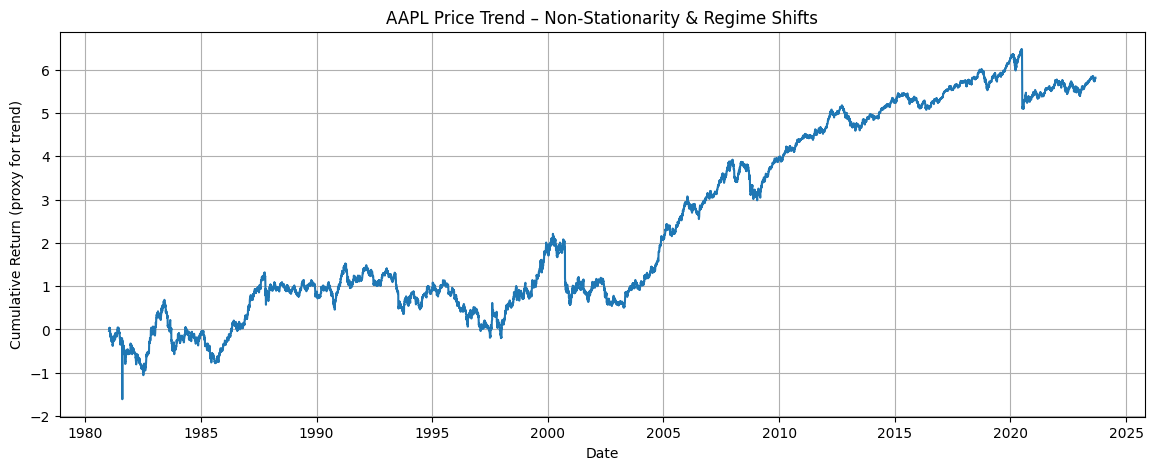

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

stock = "AAPL"
df_plot = df_price[df_price["ticker"] == stock]

plt.figure(figsize=(14,5))
plt.plot(df_plot["date"], df_plot["return"].cumsum(), label=f"{stock} Price (log-return cumulative)")
plt.title(f"{stock} Price Trend – Non-Stationarity & Regime Shifts")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (proxy for trend)")
plt.grid(True)
plt.show()


example of the 20 day rolling volatility of a stock (AAPL)

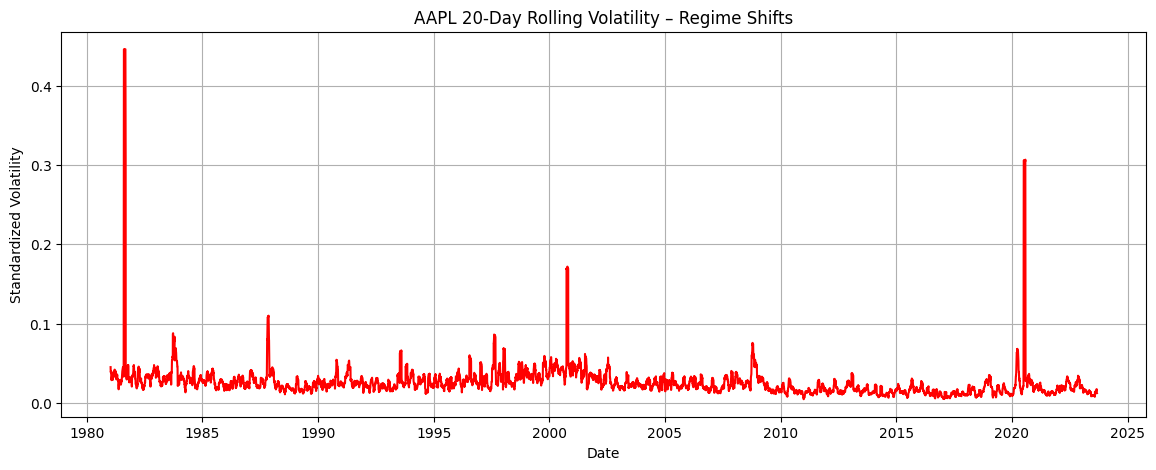

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(df_plot["date"], df_plot["volatility_20"], color="red")
plt.title(f"{stock} 20-Day Rolling Volatility – Regime Shifts")
plt.xlabel("Date")
plt.ylabel("Standardized Volatility")
plt.grid(True)
plt.show()


For the sake of saving space and to avoid reduncy we will skip the pre processing of the other 2 datasets

### **dataset of version 2: with no newscount and no sentiment and and a 5 day rolling average for the target**

In [ ]:
df2 = pd.read_csv("/content/drive/MyDrive/all_prices_clean_minimal_5day.csv")
df2.head()

,date,ticker,return,volatility_20,volume_log,target
0,2005-10-25,AAL,-0.465614,0.062383,-1.970131,0.262568
1,2005-10-26,AAL,0.450599,-0.100069,-1.849987,0.440936
2,2005-10-27,AAL,0.329910,-0.120202,-2.091606,0.530851
3,2005-10-28,AAL,1.844560,-0.026916,-1.246357,0.635914
4,2005-10-31,AAL,1.020117,-0.005984,-1.704445,0.814269


### **dataset of version 3: with newscount and sentiment and no 5 day rolling average for the target**

In [ ]:


df3 = pd.read_csv("/content/drive/MyDrive/final_dataset_standardized.csv")
df3.head()



,date,ticker,return,volatility_20,volume_log,target,news_count,sentiment_mean
0,2005-10-25,AAL,-0.465614,0.062383,-1.970131,0.450599,-0.252962,-0.301954
1,2005-10-26,AAL,0.450599,-0.100069,-1.849987,0.329910,-0.252962,-0.301954
2,2005-10-27,AAL,0.329910,-0.120202,-2.091606,1.844560,-0.252962,-0.301954
3,2005-10-28,AAL,1.844560,-0.026916,-1.246357,1.020117,-0.252962,-0.301954
4,2005-10-31,AAL,1.020117,-0.005984,-1.704445,0.426162,-0.252962,-0.301954


## **V. Transformer Baseline Results**

1.imports

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os


In [ ]:

df = pd.read_csv("/content/drive/MyDrive/all_prices_clean_minimal.csv")

feature_cols = [
    "return", "volatility_20", "volume_log"
]
target_col   = "target"

features = df[feature_cols].values.astype(float)
target   = df[target_col].values.astype(float)


### **2. Create Sliding Multivariate Sequences and Next-Step Targets (seq_len=128)**

In [ ]:
def create_windows_multivariate(features, target, seq_len=128):
    X, y = [], []
    for i in range(len(features) - seq_len):
        X.append(features[i:i+seq_len])
        y.append(target[i+seq_len])
    return np.array(X), np.array(y)

In [ ]:
SEQ_LEN = 128
X, y = create_windows_multivariate(features, target, SEQ_LEN)

print(X.shape, y.shape)
split = int(len(X) * 0.8)

X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

(47744, 128, 3) (47744,)


PyTorch Time-Series Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
train_loader_full = DataLoader(
    TimeSeriesDataset(X_train, y_train),
    batch_size=32,
    shuffle=False
)

val_loader_full = DataLoader(
    TimeSeriesDataset(X_val, y_val),
    batch_size=32,
    shuffle=False
)


Evaluation Metrics: MAE, RMSE, MASE

In [ ]:
import torch
import numpy as np

def evaluate_metrics(model, loader, device):
    model.eval()

    preds = []
    trues = []

    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device)
            yb = yb.to(device)

            out = model(Xb)

            preds.append(out.squeeze(-1).cpu())
            trues.append(yb.squeeze(-1).cpu())

    preds = torch.cat(preds)
    trues = torch.cat(trues)

    # ===== Metrics =====
    mae = torch.mean(torch.abs(preds - trues)).item()
    rmse = torch.sqrt(torch.mean((preds - trues) ** 2)).item()

    # ===== MASE =====
    # Naive forecast: y_t = y_{t-1}
    naive_errors = torch.abs(trues[1:] - trues[:-1])
    model_errors = torch.abs(preds[1:] - trues[1:])

    mase = model_errors.mean() / (naive_errors.mean() + 1e-8)
    mase = mase.item()

    return mae, rmse, mase

4. Transformer Training Loop




In [ ]:
def train_transformer(
    model,
    train_loader,
    val_loader,
    epochs=20,
    lr=3e-4,
    save_prefix="transformer"
):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=lr,
        steps_per_epoch=len(train_loader),
        epochs=epochs,
        pct_start=0.1
    )

    history = {
        "train_loss": [],
        "val_loss": [],
        "val_rmse": [],
        "val_mae": [],
        "val_mase": []
    }

    for epoch in range(1, epochs + 1):

        # =========================
        # TRAINING
        # =========================
        model.train()
        total_loss = 0.0

        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)

            optimizer.zero_grad()
            out = model(Xb)
            loss = F.mse_loss(out, yb)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)

        # =========================
        # VALIDATION LOSS (MSE)
        # =========================
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                out = model(Xb)
                val_loss += F.mse_loss(out, yb).item()

        val_loss /= len(val_loader)

        # =========================
        # VALIDATION METRICS
        # =========================
        mae, rmse, mase = evaluate_metrics(model, val_loader, device)

        print(f"\n===== Epoch {epoch:02d}/{epochs} =====")
        print(f"[Train] Loss: {train_loss:.6f}")
        print(f"[Val]   Loss: {val_loss:.6f}")
        print(f"[Val]   RMSE={rmse:.5f}, MAE={mae:.5f}, MASE={mase:.5f}")

        # =========================
        # SAVE CHECKPOINT
        # =========================
        torch.save(
            model.state_dict(),
            f"{save_prefix}_epoch{epoch:02d}.pt"
        )

        # =========================
        # LOG HISTORY (ALL FIELDS)
        # =========================
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_rmse"].append(rmse)
        history["val_mae"].append(mae)
        history["val_mase"].append(mase)

        # 🔒 Safety check
        assert len(set(len(v) for v in history.values())) == 1, \
            "History length mismatch!"

    return history


Transformer Regressor Model

In [ ]:
class TransformerRegressor(nn.Module):
    def __init__(
        self,
        d_model=64,
        nhead=4,
        num_layers=2,
        seq_len=128,
        num_features=4
    ):
        super().__init__()

        self.seq_len = seq_len
        self.d_model = d_model

        self.input_proj = nn.Linear(num_features, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dim_feedforward=256,
            dropout=0.1,
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        B, T, _ = x.shape

        x = self.input_proj(x)


        pos_embedding = torch.randn(
            1, T, self.d_model,
            device=x.device
        )

        x = x + pos_embedding
        encoded = self.encoder(x)
        last = encoded[:, -1, :]
        out = self.fc(last)
        return out


saving results

In [ ]:
import pandas as pd
import os

def save_history(history, name):
    lengths = {k: len(v) for k, v in history.items()}
    print("History lengths:", lengths)

    assert len(set(lengths.values())) == 1, \
        f"Inconsistent history lengths: {lengths}"

    df = pd.DataFrame(history)
    path = f"/content/drive/MyDrive/{name}_history.csv"
    df.to_csv(path, index=False)
    print(f"Saved → {path}")

Split Dataset into Stable, Volatile, and Full Regimes

In [ ]:
q30 = df_final["volatility_20"].quantile(0.30)
q70 = df_final["volatility_20"].quantile(0.70)

df_stable = df_final[df_final["volatility_20"] <= q30].reset_index(drop=True)
df_volatile = df_final[df_final["volatility_20"] >= q70].reset_index(drop=True)
df_mixed = df_final.copy()


### **VERSION 1 :training the transformer model on df (without 5 day rolling news and without news)**



In [ ]:
# ===== FULL =====
model_full = TransformerRegressor(
    d_model=64,
    nhead=4,
    num_layers=2,
    seq_len=128,
    num_features=len(feature_cols)
)

hist_full = train_transformer(
    model_full,
    train_loader_full,
    val_loader_full,
    epochs=20,
    save_prefix="transformer_full"
)

save_history(hist_full, "transformer_full")


===== Epoch 01/20 =====
[Train] Loss: 1.296902
[Val]   Loss: 0.279070
[Val]   RMSE=0.52738, MAE=0.36981, MASE=0.70050

===== Epoch 02/20 =====
[Train] Loss: 1.192365
[Val]   Loss: 0.268659
[Val]   RMSE=0.51858, MAE=0.36072, MASE=0.68324

===== Epoch 03/20 =====
[Train] Loss: 1.187028
[Val]   Loss: 0.268326
[Val]   RMSE=0.51824, MAE=0.36017, MASE=0.68221

===== Epoch 04/20 =====
[Train] Loss: 1.185328
[Val]   Loss: 0.268513
[Val]   RMSE=0.51835, MAE=0.36043, MASE=0.68271

===== Epoch 05/20 =====
[Train] Loss: 1.184602
[Val]   Loss: 0.268430
[Val]   RMSE=0.51837, MAE=0.36045, MASE=0.68273

===== Epoch 06/20 =====
[Train] Loss: 1.184143
[Val]   Loss: 0.268671
[Val]   RMSE=0.51841, MAE=0.36042, MASE=0.68268

===== Epoch 07/20 =====
[Train] Loss: 1.184086
[Val]   Loss: 0.268662
[Val]   RMSE=0.51846, MAE=0.36054, MASE=0.68291

===== Epoch 08/20 =====
[Train] Loss: 1.183801
[Val]   Loss: 0.268710
[Val]   RMSE=0.51849, MAE=0.36060, MASE=0.68302

===== Epoch 09/20 =====
[Train] Loss: 1.183568


Plot Training and Validation Loss Across Market Regimes

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_loss_curves():
    models = ["full", "stable", "volatile"]

    plt.figure(figsize=(14,6))

    for m in models:
        df = pd.read_csv(f"transformer_{m}_history.csv")

        plt.plot(df["train_loss"], label=f"{m} – Train")
        plt.plot(df["val_loss"],  label=f"{m} – Val", linestyle="--")

    plt.title("Transformer Training vs Validation Loss (3 regimes)")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_predictions(model, loader, device="cuda", title="Model Predictions"):
    model.eval()
    preds = []
    trues = []

    with torch.no_grad():
        for Xb, yb in loader:
            out = model(Xb.to(device))
            preds.append(out.cpu().numpy())
            trues.append(yb.cpu().numpy())

    preds = np.concatenate(preds).flatten()
    trues = np.concatenate(trues).flatten()

    plt.figure(figsize=(14,5))
    plt.plot(trues[:300], label="True")
    plt.plot(preds[:300], label="Predicted")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


loading the checkpoint path

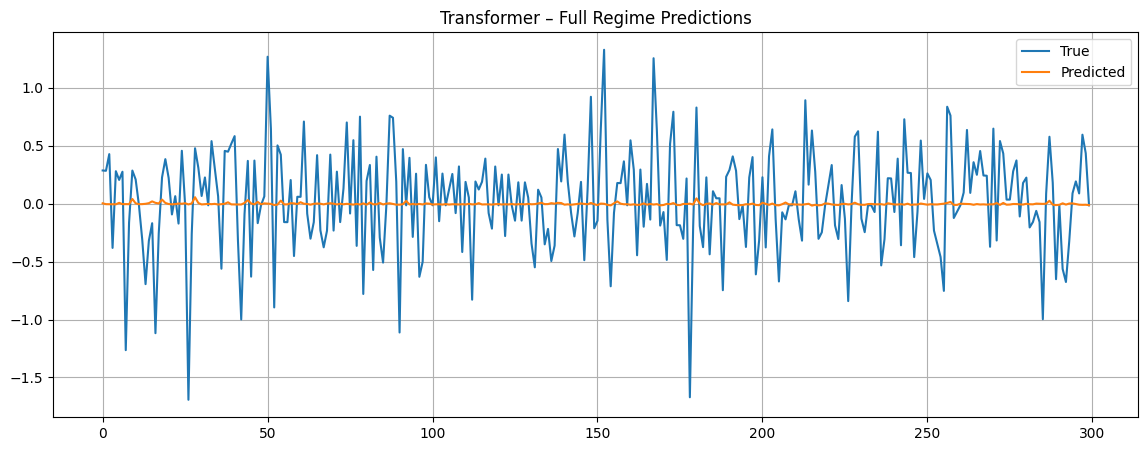

In [ ]:
plot_predictions(model_full, val_loader_full, device="cuda", title="Transformer – Full Regime Predictions")


loading volatile data


In [ ]:
features_volatile = df2_volatile[feature_cols].values
target_volatile   = df2_volatile[target_col].values

X_volatile, y_volatile = create_windows_multivariate(features_volatile, target_volatile)

split = int(len(X_volatile) * 0.8)
train_loader_volatile = DataLoader(TimeSeriesDataset(X_volatile[:split], y_volatile[:split]), batch_size=32, shuffle=True)
val_loader_volatile   = DataLoader(TimeSeriesDataset(X_volatile[split:], y_volatile[split:]), batch_size=32, shuffle=False)


In [ ]:
# ===== VOLATILE =====
model_volatile = TransformerRegressor(
    d_model=64,
    nhead=4,
    num_layers=2,
    seq_len=128,
    num_features=len(feature_cols)
)

hist_volatile = train_transformer(
    model_volatile,
    train_loader_volatile,
    val_loader_volatile,
    epochs=20,
    save_prefix="transformer_volatile"
)

save_history(hist_volatile, "transformer_volatile")



===== Epoch 01/20 =====
[Train] Loss: 2.271984
[Val]   Loss: 3.953016
[Val]   RMSE=1.99623, MAE=0.91553, MASE=0.68952

===== Epoch 02/20 =====
[Train] Loss: 2.116119
[Val]   Loss: 3.928792
[Val]   RMSE=1.98602, MAE=0.89226, MASE=0.67185

===== Epoch 03/20 =====
[Train] Loss: 2.078249
[Val]   Loss: 3.920585
[Val]   RMSE=1.98105, MAE=0.88703, MASE=0.66792

===== Epoch 04/20 =====
[Train] Loss: 2.078342
[Val]   Loss: 3.918566
[Val]   RMSE=1.97967, MAE=0.88827, MASE=0.66883

===== Epoch 05/20 =====
[Train] Loss: 2.072052
[Val]   Loss: 3.919012
[Val]   RMSE=1.97973, MAE=0.88857, MASE=0.66905

===== Epoch 06/20 =====
[Train] Loss: 2.070969
[Val]   Loss: 3.923550
[Val]   RMSE=1.98159, MAE=0.88717, MASE=0.66804

===== Epoch 07/20 =====
[Train] Loss: 2.069540
[Val]   Loss: 3.917875
[Val]   RMSE=1.97981, MAE=0.88596, MASE=0.66711

===== Epoch 08/20 =====
[Train] Loss: 2.067391
[Val]   Loss: 3.920039
[Val]   RMSE=1.97964, MAE=0.88858, MASE=0.66905

===== Epoch 09/20 =====
[Train] Loss: 2.066813



loading stable data



In [ ]:
features_stable = df2_stable[feature_cols].values
target_stable   = df2_stable[target_col].values

X_stable, y_stable = create_windows_multivariate(features_stable, target_stable)

split = int(len(X_stable) * 0.8)
train_loader_stable = DataLoader(TimeSeriesDataset(X_stable[:split], y_stable[:split]), batch_size=32, shuffle=True)
val_loader_stable   = DataLoader(TimeSeriesDataset(X_stable[split:], y_stable[split:]), batch_size=32, shuffle=False)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_loss_curves():
    models = ["full", "stable", "volatile"]

    plt.figure(figsize=(14,6))

    for m in models:
        df2 = pd.read_csv(f"transformer_{m}_history.csv")

        plt.plot(df["train_loss"], label=f"{m} – Train")
        plt.plot(df["val_loss"],  label=f"{m} – Val", linestyle="--")

    plt.title("Transformer Training vs Validation Loss (3 regimes)")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
features_volatile = df_volatile[feature_cols].values
target_volatile   = df_volatile[target_col].values

X_volatile, y_volatile = create_windows_multivariate(features_volatile, target_volatile)

split = int(len(X_volatile) * 0.8)
train_loader_volatile = DataLoader(TimeSeriesDataset(X_volatile[:split], y_volatile[:split]), batch_size=32, shuffle=True)
val_loader_volatile   = DataLoader(TimeSeriesDataset(X_volatile[split:], y_volatile[split:]), batch_size=32, shuffle=False)


In [ ]:
# ===== VOLATILE =====
model_volatile = TransformerRegressor(
    d_model=64,
    nhead=4,
    num_layers=2,
    seq_len=128,
    num_features=len(feature_cols)
)

hist_volatile = train_transformer(
    model_volatile,
    train_loader_volatile,
    val_loader_volatile,
    epochs=20,
    save_prefix="transformer_volatile"
)

save_history(hist_volatile, "transformer_volatile")



===== Epoch 01/20 =====
[Train] Loss: 2.250412
[Val]   Loss: 3.952141
[Val]   RMSE=2.00056, MAE=0.92708, MASE=0.69803

===== Epoch 02/20 =====
[Train] Loss: 2.094521
[Val]   Loss: 3.938906
[Val]   RMSE=1.98311, MAE=0.89974, MASE=0.67745

===== Epoch 03/20 =====
[Train] Loss: 2.072843
[Val]   Loss: 3.916270
[Val]   RMSE=1.97952, MAE=0.88899, MASE=0.66935

===== Epoch 04/20 =====
[Train] Loss: 2.067976
[Val]   Loss: 3.919733
[Val]   RMSE=1.97982, MAE=0.88635, MASE=0.66741

===== Epoch 05/20 =====
[Train] Loss: 2.071201
[Val]   Loss: 3.919257
[Val]   RMSE=1.97956, MAE=0.88776, MASE=0.66843

===== Epoch 06/20 =====
[Train] Loss: 2.067411
[Val]   Loss: 3.917100
[Val]   RMSE=1.97946, MAE=0.88597, MASE=0.66710

===== Epoch 07/20 =====
[Train] Loss: 2.070542
[Val]   Loss: 3.917715
[Val]   RMSE=1.97933, MAE=0.88571, MASE=0.66692

===== Epoch 08/20 =====
[Train] Loss: 2.067571
[Val]   Loss: 3.916510
[Val]   RMSE=1.97926, MAE=0.88713, MASE=0.66797

===== Epoch 09/20 =====
[Train] Loss: 2.067180


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_loss_curves():
    models = ["full", "stable", "volatile"]

    plt.figure(figsize=(14,6))
    for m in models:
        df = pd.read_csv(f"transformer_{m}_history.csv")

        plt.plot(df["train_loss"], label=f"{m} – Train")
        plt.plot(df["val_loss"],  label=f"{m} – Val", linestyle="--")

    plt.title("Transformer Training vs Validation Loss (3 regimes)")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

### **VERSION 2.Using less volatile data 5 day rolling return as a target**
these are just the results to avoid redundancy

In [ ]:
# ===== FULL =====
model_full = TransformerRegressor(
    d_model=64,
    nhead=4,
    num_layers=2,
    seq_len=128,
    num_features=len(feature_cols)
)

hist_full = train_transformer(
    model_full,
    train_loader_full,
    val_loader_full,
    epochs=20,
    save_prefix="transformer_full"
)

save_history(hist_full, "transformer_full")



===== Epoch 01/20 =====
[Train] Loss: 0.211241
[Val]   Loss: 0.037146
[Val]   RMSE=0.19283, MAE=0.13804, MASE=1.33410

===== Epoch 02/20 =====
[Train] Loss: 0.176286
[Val]   Loss: 0.021544
[Val]   RMSE=0.14680, MAE=0.10206, MASE=0.98635

===== Epoch 03/20 =====
[Train] Loss: 0.134636
[Val]   Loss: 0.020136
[Val]   RMSE=0.14195, MAE=0.10090, MASE=0.97511

===== Epoch 04/20 =====
[Train] Loss: 0.131637
[Val]   Loss: 0.019870
[Val]   RMSE=0.14098, MAE=0.09961, MASE=0.96264

===== Epoch 05/20 =====
[Train] Loss: 0.124854
[Val]   Loss: 0.020321
[Val]   RMSE=0.14257, MAE=0.10026, MASE=0.96889

===== Epoch 06/20 =====
[Train] Loss: 0.125879
[Val]   Loss: 0.020675
[Val]   RMSE=0.14380, MAE=0.10095, MASE=0.97563

===== Epoch 07/20 =====
[Train] Loss: 0.124147
[Val]   Loss: 0.020477
[Val]   RMSE=0.14311, MAE=0.10078, MASE=0.97391

===== Epoch 08/20 =====
[Train] Loss: 0.128057
[Val]   Loss: 0.020612
[Val]   RMSE=0.14358, MAE=0.10142, MASE=0.98013

===== Epoch 09/20 =====
[Train] Loss: 0.121140


In [ ]:
for k, v in hist_full.items():
    print(k, len(v))


train_loss 20
val_loss 0
val_rmse 20
val_mae 20
val_mase 20


In [ ]:
train_ds = TimeSeriesDataset(X_train, y_train)
val_ds   = TimeSeriesDataset(X_val, y_val)

train_loader_full = DataLoader(train_ds, batch_size=32, shuffle=False)
val_loader_full   = DataLoader(val_ds, batch_size=32, shuffle=False)


In [ ]:
features_stable = df2_stable[feature_cols].values
target_stable   = df2_stable[target_col].values

X_stable, y_stable = create_windows_multivariate(features_stable, target_stable)

split = int(len(X_stable) * 0.8)
train_loader_stable = DataLoader(TimeSeriesDataset(X_stable[:split], y_stable[:split]), batch_size=32, shuffle=True)
val_loader_stable   = DataLoader(TimeSeriesDataset(X_stable[split:], y_stable[split:]), batch_size=32, shuffle=False)


In [ ]:
# ===== STABLE =====
model_stable = TransformerRegressor(
    d_model=64,
    nhead=4,
    num_layers=2,
    seq_len=128,
    num_features=len(feature_cols)
)

hist_stable = train_transformer(
    model_stable,
    train_loader_stable,
    val_loader_stable,
    epochs=20,
    save_prefix="transformer_stable"
)

save_history(hist_stable, "transformer_stable")



===== Epoch 01/20 =====
[Train] Loss: 0.243368
[Val]   Loss: 0.131078
[Val]   RMSE=0.36200, MAE=0.27142, MASE=0.70020

===== Epoch 02/20 =====
[Train] Loss: 0.177604
[Val]   Loss: 0.128710
[Val]   RMSE=0.35871, MAE=0.26643, MASE=0.68728

===== Epoch 03/20 =====
[Train] Loss: 0.174428
[Val]   Loss: 0.128273
[Val]   RMSE=0.35810, MAE=0.26635, MASE=0.68710

===== Epoch 04/20 =====
[Train] Loss: 0.173641
[Val]   Loss: 0.128176
[Val]   RMSE=0.35797, MAE=0.26634, MASE=0.68708

===== Epoch 05/20 =====
[Train] Loss: 0.173028
[Val]   Loss: 0.137516
[Val]   RMSE=0.37078, MAE=0.27676, MASE=0.71385

===== Epoch 06/20 =====
[Train] Loss: 0.172820
[Val]   Loss: 0.129796
[Val]   RMSE=0.36022, MAE=0.26766, MASE=0.69045

===== Epoch 07/20 =====
[Train] Loss: 0.171867
[Val]   Loss: 0.128109
[Val]   RMSE=0.35787, MAE=0.26614, MASE=0.68656

===== Epoch 08/20 =====
[Train] Loss: 0.171304
[Val]   Loss: 0.128902
[Val]   RMSE=0.35898, MAE=0.26670, MASE=0.68798

===== Epoch 09/20 =====
[Train] Loss: 0.171570


In [ ]:
features_volatile = df2_volatile[feature_cols].values
target_volatile   = df2_volatile[target_col].values

X_volatile, y_volatile = create_windows_multivariate(features_volatile, target_volatile)

split = int(len(X_volatile) * 0.8)
train_loader_volatile = DataLoader(TimeSeriesDataset(X_volatile[:split], y_volatile[:split]), batch_size=32, shuffle=True)
val_loader_volatile   = DataLoader(TimeSeriesDataset(X_volatile[split:], y_volatile[split:]), batch_size=32, shuffle=False)


In [ ]:
# ===== VOLATILE =====
model_volatile = TransformerRegressor(
    d_model=64,
    nhead=4,
    num_layers=2,
    seq_len=128,
    num_features=len(feature_cols)
)

hist_volatile = train_transformer(
    model_volatile,
    train_loader_volatile,
    val_loader_volatile,
    epochs=20,
    save_prefix="transformer_volatile"
)

save_history(hist_volatile, "transformer_volatile")



===== Epoch 01/20 =====
[Train] Loss: 0.387522
[Val]   Loss: 0.674755
[Val]   RMSE=0.82156, MAE=0.40775, MASE=1.44182

===== Epoch 02/20 =====
[Train] Loss: 0.318199
[Val]   Loss: 0.626546
[Val]   RMSE=0.79167, MAE=0.36194, MASE=1.27972

===== Epoch 03/20 =====
[Train] Loss: 0.244228
[Val]   Loss: 0.580706
[Val]   RMSE=0.76216, MAE=0.31477, MASE=1.11296

===== Epoch 04/20 =====
[Train] Loss: 0.220345
[Val]   Loss: 0.573233
[Val]   RMSE=0.75724, MAE=0.30394, MASE=1.07465

===== Epoch 05/20 =====
[Train] Loss: 0.216187
[Val]   Loss: 0.576729
[Val]   RMSE=0.75955, MAE=0.30959, MASE=1.09471

===== Epoch 06/20 =====
[Train] Loss: 0.211133
[Val]   Loss: 0.549034
[Val]   RMSE=0.74108, MAE=0.29835, MASE=1.05489

===== Epoch 07/20 =====
[Train] Loss: 0.203101
[Val]   Loss: 0.567287
[Val]   RMSE=0.75331, MAE=0.29559, MASE=1.04516

===== Epoch 08/20 =====
[Train] Loss: 0.204354
[Val]   Loss: 0.534408
[Val]   RMSE=0.73115, MAE=0.29067, MASE=1.02781

===== Epoch 09/20 =====
[Train] Loss: 0.200369


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_loss_curves():
    models = ["full", "stable", "volatile"]

    plt.figure(figsize=(14,6))

    for m in models:
        df2 = pd.read_csv(f"transformer_{m}_history.csv")

        plt.plot(df2["train_loss"], label=f"{m} – Train")
                           plt.plot(df2["val_loss"],  label=f"{m} – Val", linestyle="--")

    plt.title("Transformer Training vs Validation Loss (3 regimes)")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_predictions(model, loader, device="cuda", title="Model Predictions"):
    model.eval()
    preds = []
    trues = []

    with torch.no_grad():
        for Xb, yb in loader:
            out = model(Xb.to(device))
            preds.append(out.cpu().numpy())
            trues.append(yb.cpu().numpy())

    preds = np.concatenate(preds).flatten()
    trues = np.concatenate(trues).flatten()

    plt.figure(figsize=(14,5))
    plt.plot(trues[:300], label="True")
    plt.plot(preds[:300], label="Predicted")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


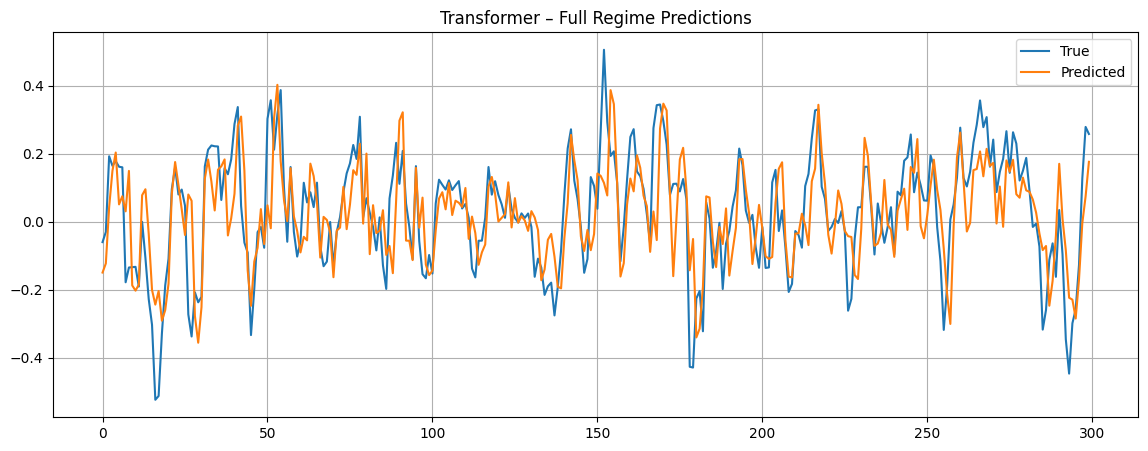

In [ ]:
plot_predictions(model, val_loader_full, device="cuda", title="Transformer – Full Regime Predictions")

In [ ]:
import torch
import os
import pandas as pd

def evaluate_checkpoints(prefix, model, loader, device="cuda"):
    device = device if torch.cuda.is_available() else "cpu"

    rows = []
    found_files = 0
    processed_files = 0

    # scan working directory for matching checkpoint files
    print(f"Searching for checkpoints with prefix '{prefix}' in {os.getcwd()}")
    for file in sorted(os.listdir(".")):
        if file.startswith(prefix) and file.endswith(".pt"):
            found_files += 1
            try:
                # Extract epoch number
                epoch = int(file.split("epoch")[1].split(".")[0])

                # Load checkpoint into model
                model.load_state_dict(torch.load(file, map_location=device))

                # Evaluate
                mae, rmse, mase = evaluate_metrics(model, loader, device)

                print(f"Epoch {epoch:02d} → RMSE={rmse:.4f}, MAE={mae:.4f}, MASE={mase:.4f}")
                processed_files += 1

                rows.append({
                    "epoch": epoch,
                    "mae": mae,
                    "rmse": rmse,
                    "mase": mase
                })
            except Exception as e:
                print(f"Error processing checkpoint '{file}': {e}") # Print specific error
                continue

    if not rows:
        print(f"Warning: No checkpoint metrics collected for prefix '{prefix}'. Found {found_files} matching files, processed {processed_files}. Returning empty DataFrame.")
        return pd.DataFrame(columns=['epoch', 'mae', 'rmse', 'mase'])

    # Return as DataFrame for charting
    df =pd.DataFrame(rows).sort_values("epoch").reset_index(drop=True)
    return df

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_checkpoint_metrics(df, title):
    if df.empty:
        print(f"Warning: Cannot plot metrics for '{title}' because the DataFrame is empty.")
        return

    plt.figure(figsize=(12,5))
    plt.plot(df["epoch"], df["rmse"], label="RMSE")
    plt.plot(df["epoch"], df["mae"], label="MAE")
    plt.plot(df["epoch"], df["mase"], label="MASE")

    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Metric Value")
    plt.grid(True)
    plt.legend()
    plt.show()

Searching for checkpoints with prefix 'transformer_full' in /content
Epoch 01 → RMSE=0.1928, MAE=0.1380, MASE=1.3341
Epoch 02 → RMSE=0.1468, MAE=0.1021, MASE=0.9863
Epoch 03 → RMSE=0.1419, MAE=0.1009, MASE=0.9751
Epoch 04 → RMSE=0.1410, MAE=0.0996, MASE=0.9626
Epoch 05 → RMSE=0.1426, MAE=0.1003, MASE=0.9689
Epoch 06 → RMSE=0.1438, MAE=0.1010, MASE=0.9756
Epoch 07 → RMSE=0.1431, MAE=0.1008, MASE=0.9739
Epoch 08 → RMSE=0.1436, MAE=0.1014, MASE=0.9801
Epoch 09 → RMSE=0.1421, MAE=0.1004, MASE=0.9705
Epoch 10 → RMSE=0.1406, MAE=0.0994, MASE=0.9607
Epoch 11 → RMSE=0.1404, MAE=0.0995, MASE=0.9613
Epoch 12 → RMSE=0.1416, MAE=0.1004, MASE=0.9704
Epoch 13 → RMSE=0.1435, MAE=0.1020, MASE=0.9859
Epoch 14 → RMSE=0.1434, MAE=0.1021, MASE=0.9869
Epoch 15 → RMSE=0.1421, MAE=0.1009, MASE=0.9747
Epoch 16 → RMSE=0.1411, MAE=0.1000, MASE=0.9660
Epoch 17 → RMSE=0.1407, MAE=0.0998, MASE=0.9640
Epoch 18 → RMSE=0.1409, MAE=0.0999, MASE=0.9654
Epoch 19 → RMSE=0.1412, MAE=0.1000, MASE=0.9668
Epoch 20 → RMSE=0.1

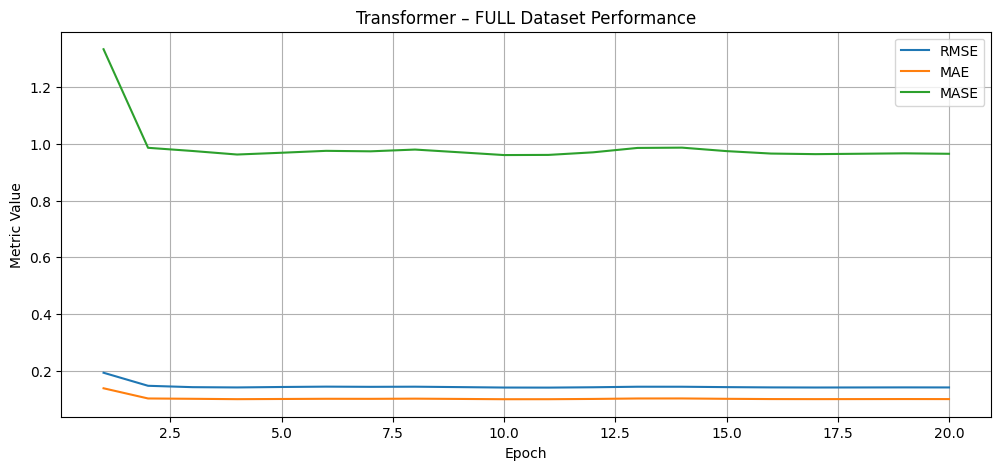

In [ ]:
df_full_metrics = evaluate_checkpoints("transformer_full", model, val_loader_full)
plot_checkpoint_metrics(df_full_metrics, "Transformer – FULL Dataset Performance")

Searching for checkpoints with prefix 'transformer_stable' in /content
Epoch 01 → RMSE=0.3620, MAE=0.2714, MASE=0.7002
Epoch 02 → RMSE=0.3587, MAE=0.2664, MASE=0.6873
Epoch 03 → RMSE=0.3581, MAE=0.2664, MASE=0.6871
Epoch 04 → RMSE=0.3580, MAE=0.2663, MASE=0.6871
Epoch 05 → RMSE=0.3708, MAE=0.2768, MASE=0.7139
Epoch 06 → RMSE=0.3602, MAE=0.2677, MASE=0.6904
Epoch 07 → RMSE=0.3579, MAE=0.2661, MASE=0.6866
Epoch 08 → RMSE=0.3590, MAE=0.2667, MASE=0.6880
Epoch 09 → RMSE=0.3579, MAE=0.2661, MASE=0.6865
Epoch 10 → RMSE=0.3578, MAE=0.2662, MASE=0.6867
Epoch 11 → RMSE=0.3598, MAE=0.2674, MASE=0.6897
Epoch 12 → RMSE=0.3589, MAE=0.2666, MASE=0.6878
Epoch 13 → RMSE=0.3579, MAE=0.2662, MASE=0.6868
Epoch 14 → RMSE=0.3617, MAE=0.2688, MASE=0.6935
Epoch 15 → RMSE=0.3584, MAE=0.2663, MASE=0.6869
Epoch 16 → RMSE=0.3581, MAE=0.2662, MASE=0.6866
Epoch 17 → RMSE=0.3599, MAE=0.2674, MASE=0.6898
Epoch 18 → RMSE=0.3590, MAE=0.2667, MASE=0.6880
Epoch 19 → RMSE=0.3588, MAE=0.2665, MASE=0.6875
Epoch 20 → RMSE=0

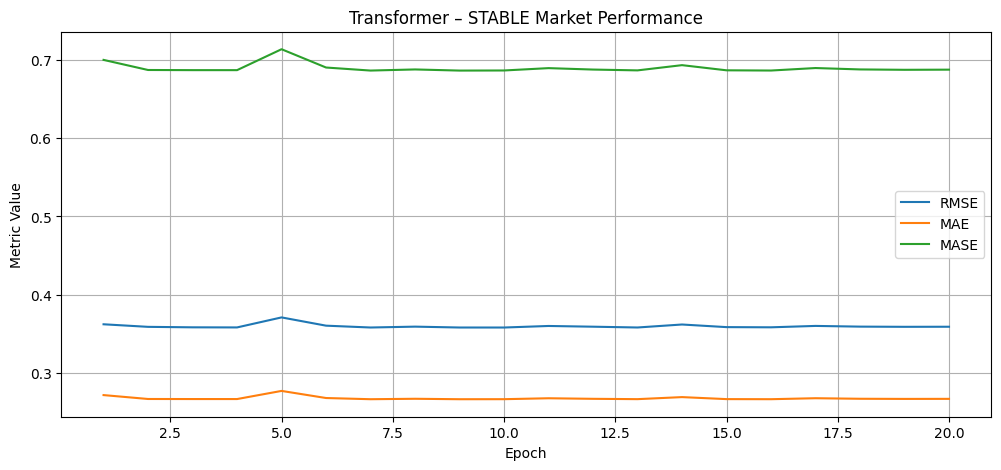

In [ ]:
df_stable_metrics = evaluate_checkpoints("transformer_stable", model, val_loader_stable)
plot_checkpoint_metrics(df_stable_metrics, "Transformer – STABLE Market Performance")


Searching for checkpoints with prefix 'transformer_volatile' in /content
Epoch 01 → RMSE=0.8216, MAE=0.4077, MASE=1.4418
Epoch 02 → RMSE=0.7917, MAE=0.3619, MASE=1.2797
Epoch 03 → RMSE=0.7622, MAE=0.3148, MASE=1.1130
Epoch 04 → RMSE=0.7572, MAE=0.3039, MASE=1.0747
Epoch 05 → RMSE=0.7595, MAE=0.3096, MASE=1.0947
Epoch 06 → RMSE=0.7411, MAE=0.2983, MASE=1.0549
Epoch 07 → RMSE=0.7533, MAE=0.2956, MASE=1.0452
Epoch 08 → RMSE=0.7311, MAE=0.2907, MASE=1.0278
Epoch 09 → RMSE=0.7534, MAE=0.2956, MASE=1.0453
Epoch 10 → RMSE=0.7172, MAE=0.2991, MASE=1.0576
Epoch 11 → RMSE=0.7798, MAE=0.3260, MASE=1.1528
Epoch 12 → RMSE=0.7197, MAE=0.3060, MASE=1.0821
Epoch 13 → RMSE=0.7116, MAE=0.2905, MASE=1.0273
Epoch 14 → RMSE=0.7248, MAE=0.3036, MASE=1.0736
Epoch 15 → RMSE=0.6979, MAE=0.2899, MASE=1.0252
Epoch 16 → RMSE=0.7204, MAE=0.3029, MASE=1.0712
Epoch 17 → RMSE=0.7204, MAE=0.3029, MASE=1.0711
Epoch 18 → RMSE=0.7193, MAE=0.3007, MASE=1.0633
Epoch 19 → RMSE=0.7245, MAE=0.3040, MASE=1.0748
Epoch 20 → RMSE

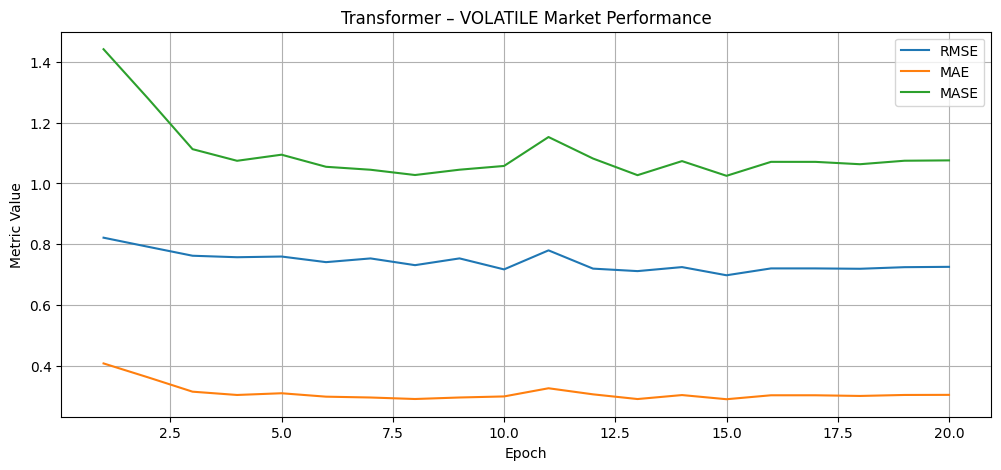

In [ ]:
df_volatile_metrics = evaluate_checkpoints("transformer_volatile", model, val_loader_volatile)
plot_checkpoint_metrics(df_volatile_metrics, "Transformer – VOLATILE Market Performance")


In [ ]:
import os
print("Current working directory:", os.getcwd())
print("Files in current directory:")
for f in os.listdir('.'):
    if 'transformer_full' in f and f.endswith('.pt'):
        print(f)
print("\nAll files in current directory:")
print(os.listdir('.'))

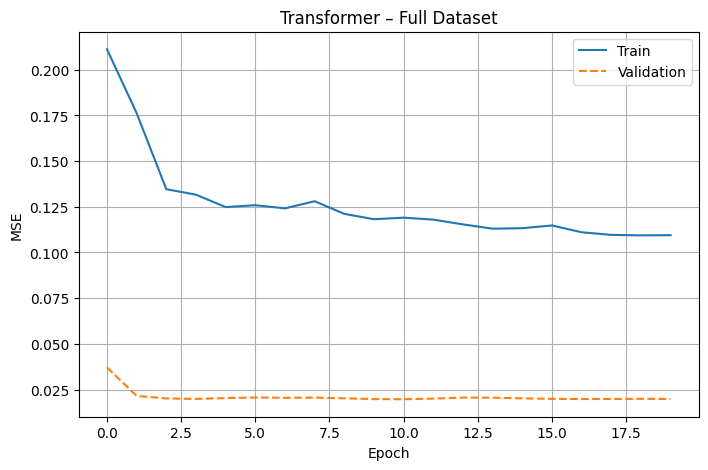

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os # Import os module

def plot_loss(history_file, title):
    # Construct the full path to the history file




    df = pd.read_csv("/content/drive/MyDrive/transformer_full_history.csv")
    plt.figure(figsize=(8,5))
    plt.plot(df["train_loss"], label="Train")
    plt.plot(df["val_loss"], label="Validation", linestyle="--")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss("transformer_full_history.csv", "Transformer – Full Dataset")


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

BASE_PATH = "/content/drive/MyDrive"


In [ ]:
def plot_loss_curves():
    models = ["full", "stable", "volatile"]

    plt.figure(figsize=(14,6))

    for m in models:
        path = os.path.join(BASE_PATH, f"transformer_{m}_history.csv")
        df2 = pd.read_csv(path)

        plt.plot(df2["train_loss"], label=f"{m.capitalize()} – Train")
        if "val_loss" in df.columns:
            plt.plot(df["val_loss"], linestyle="--", label=f"{m.capitalize()} – Val")

    plt.title("Transformer Training vs Validation Loss (All Regimes)")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


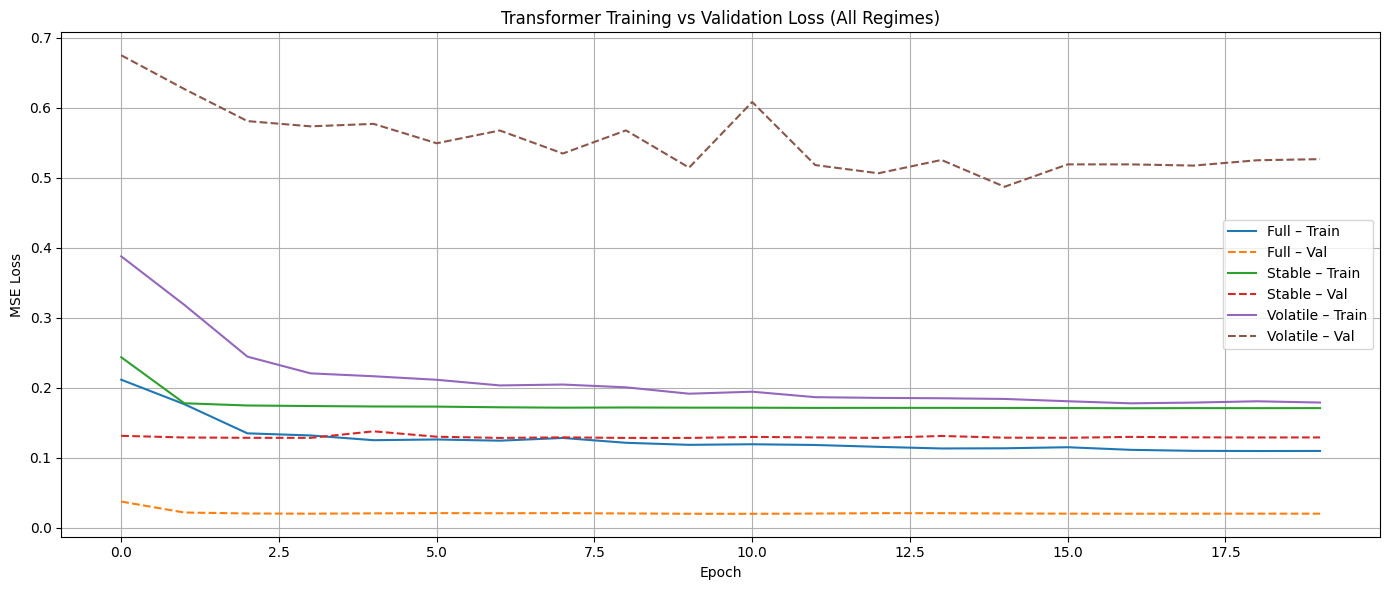

In [ ]:
plot_loss_curves()


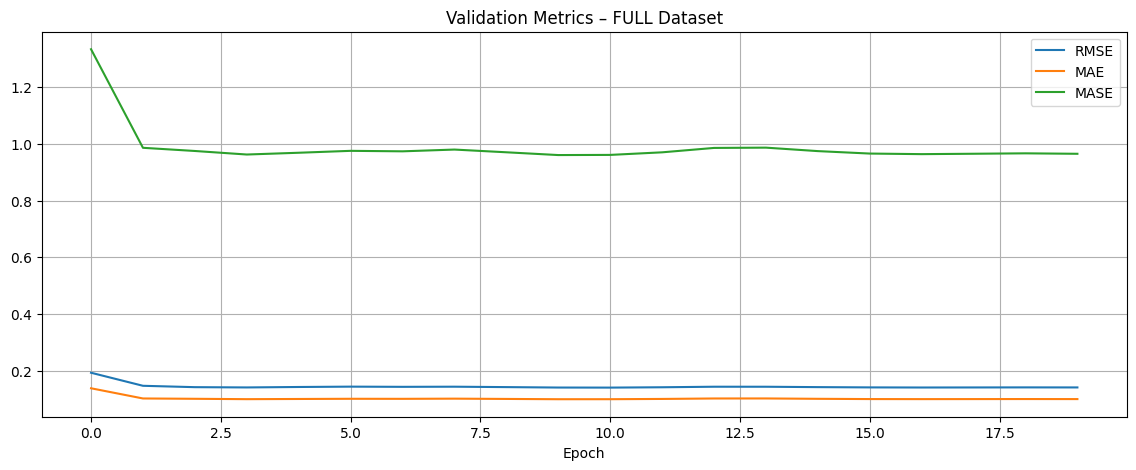

In [ ]:
df2_full = pd.read_csv(os.path.join(BASE_PATH, "transformer_full_history.csv"))

plt.figure(figsize=(14,5))
plt.plot(df2_full["val_rmse"], label="RMSE")
plt.plot(df2_full["val_mae"],  label="MAE")
plt.plot(df2_full["val_mase"], label="MASE")
plt.title("Validation Metrics – FULL Dataset")
plt.xlabel("Epoch")
plt.grid(True)
plt.legend()
plt.show()


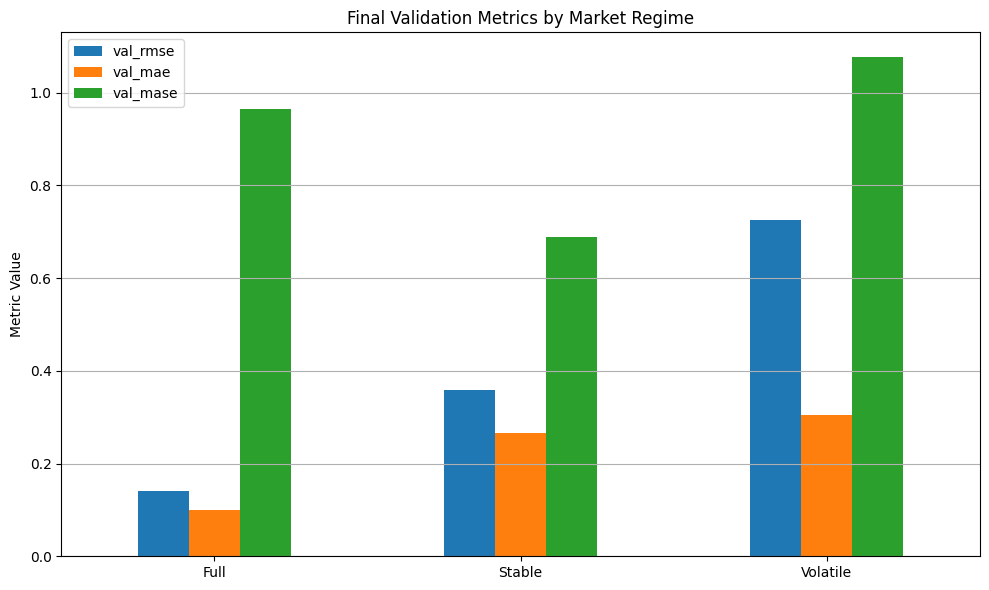

In [ ]:
def load_last_metrics(name):
    df2 = pd.read_csv(os.path.join(BASE_PATH, f"transformer_{name}_history.csv"))
    return df2.iloc[-1][["val_rmse", "val_mae", "val_mase"]]

metrics = pd.DataFrame({
    "Full": load_last_metrics("full"),
    "Stable": load_last_metrics("stable"),
    "Volatile": load_last_metrics("volatile"),
}).T

metrics.plot(kind="bar", figsize=(10,6))
plt.title("Final Validation Metrics by Market Regime")
plt.ylabel("Metric Value")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


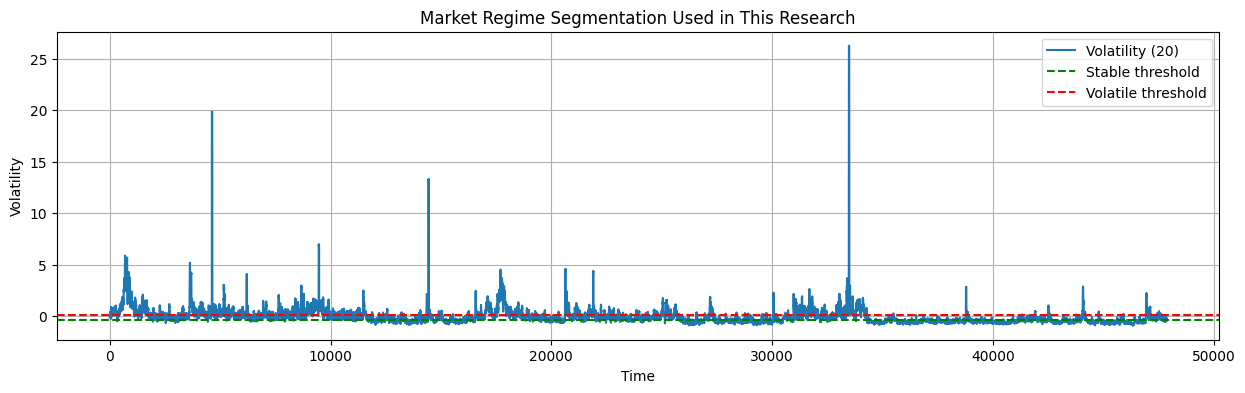

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(df2_final["volatility_20"], label="Volatility (20)")
plt.axhline(q30, color="green", linestyle="--", label="Stable threshold")
plt.axhline(q70, color="red", linestyle="--", label="Volatile threshold")
plt.title("Market Regime Segmentation Used in This Research")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()


### **VERSION 3:df3 without 5 day rolling and with the newscount and sentiment**

we notice that the results are similar to the version 1 as we see little to no contribution from the news

In [ ]:
# ===== FULL =====
model_full = TransformerRegressor(
    d_model=64,
    nhead=4,
    num_layers=2,
    seq_len=128,
    num_features=len(feature_cols)
)

hist_full = train_transformer(
    model_full,
    train_loader_full,
    val_loader_full,
    epochs=20,
    save_prefix="transformer_full"
)

save_history(hist_full, "transformer_full")



===== Epoch 01/20 =====
[Train] Loss: 1.198816
[Val]   Loss: 0.268867
[Val]   RMSE=0.51871, MAE=0.36090, MASE=0.68359

===== Epoch 02/20 =====
[Train] Loss: 1.192439
[Val]   Loss: 0.268397
[Val]   RMSE=0.51826, MAE=0.36034, MASE=0.68252

===== Epoch 03/20 =====
[Train] Loss: 1.187671
[Val]   Loss: 0.268127
[Val]   RMSE=0.51799, MAE=0.35998, MASE=0.68184

===== Epoch 04/20 =====
[Train] Loss: 1.185876
[Val]   Loss: 0.268331
[Val]   RMSE=0.51819, MAE=0.36015, MASE=0.68217

===== Epoch 05/20 =====
[Train] Loss: 1.184961
[Val]   Loss: 0.268326
[Val]   RMSE=0.51818, MAE=0.36014, MASE=0.68216

===== Epoch 06/20 =====
[Train] Loss: 1.184588
[Val]   Loss: 0.268502
[Val]   RMSE=0.51835, MAE=0.36040, MASE=0.68264

===== Epoch 07/20 =====
[Train] Loss: 1.184090
[Val]   Loss: 0.268462
[Val]   RMSE=0.51831, MAE=0.36037, MASE=0.68259

===== Epoch 08/20 =====
[Train] Loss: 1.183474
[Val]   Loss: 0.268600
[Val]   RMSE=0.51844, MAE=0.36046, MASE=0.68277

===== Epoch 09/20 =====
[Train] Loss: 1.183623




## **IV.Training & Evaluation**

### **1. Windowing + Regime Functions**

>



In [ ]:
# 1. Windowing + regime labeling

seq_len    = 128   # window length (days)
batch_size = 1     # per ticker (stock)

FEATURE_COLS = ["return", "volatility_20", "volume_log"]
TARGET_COL   = "target"
VOL_COL      = "volatility_20"
DATE_COL     = "date"
TICKER_COL   = "ticker"

def make_block_windows_with_regime(df: pd.DataFrame, seq_len: int, vol_quantile: float = 0.7):
    df = df.copy()
    df[DATE_COL] = pd.to_datetime(df[DATE_COL])
    df = df.sort_values(["ticker", DATE_COL]).reset_index(drop=True)

    windows_X = []
    windows_y = []
    windows_vol = []
    windows_ticker = []

    tickers = df["ticker"].unique().tolist()
    ticker2id = {t:i for i,t in enumerate(tickers)}

    for tkr, g in df.groupby("ticker", sort=False):
        values  = g[FEATURE_COLS].values.astype("float32")
        targets = g["target"].values.astype("float32")
        vol     = g["volatility_20"].values.astype("float32")

        n = len(g)
        assert n % seq_len == 0, f"{tkr} length not multiple of {seq_len}"

        for i in range(0, n, seq_len):
            x_win = values[i:i+seq_len]        # [128, 3]
            y_t   = targets[i+seq_len-1]
            v_win = vol[i:i+seq_len]

            windows_X.append(x_win)
            windows_y.append(y_t)
            windows_vol.append(v_win.mean())
            windows_ticker.append(ticker2id[tkr])

    X = np.stack(windows_X)
    y = np.array(windows_y)
    vol_means = np.array(windows_vol)
    ticker_ids = np.array(windows_ticker)

    thr = np.quantile(vol_means, vol_quantile)
    regime = (vol_means >= thr).astype("int64")

    print(f"Windows: {X.shape}, input_dim={X.shape[-1]}")
    print(f"Stable={np.sum(regime==0)}, Volatile={np.sum(regime==1)}")

    return X, y, regime, ticker_ids, ticker2id

### **3.Dataset & Train/val Split**

In [ ]:

class FinancialWindowDataset(Dataset):
    def __init__(self, X, y, regime, ticker_ids):
        self.X = torch.from_numpy(X)              # [N, T, F]
        self.y = torch.from_numpy(y)              # [N]
        self.regime = torch.from_numpy(regime)    # [N]
        self.ticker_ids = torch.from_numpy(ticker_ids)  # [N]

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return {
            "x": self.X[idx],                 # [T, F]
            "y": self.y[idx],                 # scalar
            "regime": self.regime[idx],       # 0/1
            "ticker_id": self.ticker_ids[idx] # int
        }

X, y, regime, ticker_ids, ticker2id = make_block_windows_with_regime(df, seq_len=seq_len, vol_quantile=0.7)

num_samples, _, input_dim = X.shape
print("Windows:", X.shape, "Input_dim:", input_dim)

dataset = FinancialWindowDataset(X, y, regime, ticker_ids)

train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size

# chronological split: first 80% train, last 20% val
def time_split_indices_by_ticker(ticker_ids, val_ratio=0.2):
    ticker_ids = np.asarray(ticker_ids)
    train_idx = []
    val_idx = []

    for t in np.unique(ticker_ids):
        idx = np.where(ticker_ids == t)[0]
        # idx is already in time order because we appended windows sequentially per ticker
        cut = int(len(idx) * (1 - val_ratio))
        train_idx.extend(idx[:cut])
        val_idx.extend(idx[cut:])

    return np.array(train_idx), np.array(val_idx)

train_idx, val_idx = time_split_indices_by_ticker(ticker_ids, val_ratio=0.2)



train_dataset = torch.utils.data.Subset(dataset, train_idx.tolist())
val_dataset   = torch.utils.data.Subset(dataset, val_idx.tolist())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, drop_last=False)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")


Windows: (4, 128, 3), input_dim=3
Stable=3, Volatile=1
Windows: (4, 128, 3) Input_dim: 3
Train batches: 3, Val batches: 1


### **3. Helper: metrics (RMSE, MAE, MASE)**

In [ ]:
def update_metric_sums(batch_y_true, batch_y_pred, batch_naive,
                       agg_dict, regime=None):
    """
    agg_dict: dict storing 'se', 'ae', 'ae_naive', 'n' optionally per regime.
    If regime is None → global; else regime is tensor[batch] with 0/1.
    """

    y_true  = batch_y_true.detach()
    y_pred  = batch_y_pred.detach()
    naive   = batch_naive.detach()

    if regime is None:
        key = "global"
        mask = torch.ones_like(y_true, dtype=torch.bool)
    else:
        # handle both regimes separately
        for r_val in [0, 1]:
            mask = (regime == r_val)
            if mask.sum() == 0:
                continue
            k = f"reg_{r_val}"

            if k not in agg_dict:
                agg_dict[k] = {"se":0.0, "ae":0.0, "ae_naive":0.0, "n":0}

            yt = y_true[mask]
            yp = y_pred[mask]
            nv = naive[mask]

            agg_dict[k]["se"]       += ((yp - yt)**2).sum().item()
            agg_dict[k]["ae"]       += (yp - yt).abs().sum().item()
            agg_dict[k]["ae_naive"] += (yt - nv).abs().sum().item()
            agg_dict[k]["n"]        += yt.numel()

        return

    # global branch
    if key not in agg_dict:
        agg_dict[key] = {"se":0.0, "ae":0.0, "ae_naive":0.0, "n":0}

    agg_dict[key]["se"]       += ((y_pred - y_true)**2).sum().item()
    agg_dict[key]["ae"]       += (y_pred - y_true).abs().sum().item()
    agg_dict[key]["ae_naive"] += (y_true - naive).abs().sum().item()
    agg_dict[key]["n"]        += y_true.numel()


In [ ]:
def compute_metrics(agg_dict):
    metrics = {}
    for k, v in agg_dict.items():
        if v["n"] == 0:
            continue
        mse   = v["se"] / v["n"]
        rmse  = math.sqrt(mse)
        mae   = v["ae"] / v["n"]
        mae_naive = max(v["ae_naive"] / v["n"], 1e-8)   # avoid /0
        mase  = mae / mae_naive
        metrics[k] = {"RMSE": rmse, "MAE": mae, "MASE": mase}
    return metrics


### **4. Instantiate MAG-Titan**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
# ===============================
# Training params
# ===============================

num_epochs = 20
lr = 1e-4

model = MagTitan(
    input_dim=input_dim,
    model_dim=128,
    num_heads=4,
    chunk_size=1,    # memory update chunk size
    memory_units=4,
    use_gating=True,
    use_surprise=True,
    use_adaptive_forgetting=True
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.MSELoss()


### **5. Training loop**

In [ ]:
for epoch in range(num_epochs):
    print(f"\n===== Epoch {epoch} / {num_epochs} =====")

    # ---------------------- TRAIN ----------------------
    model.train()

    train_loss = 0.0
    train_metrics_agg = {}   # global metrics

    gate_means = []
    mem_rates  = []

    prev_ticker = None
    for batch in train_loader:
        tkr = batch["ticker_id"][0].item()  # assumes batch is same ticker (true if dataset is ordered by ticker)
        if prev_ticker is None or tkr != prev_ticker:
            model.mem_state = None
            prev_ticker = tkr

        x = batch["x"].to(device)              # [B, T, F]
        y = batch["y"].to(device)              # [B]
        reg = batch["regime"].to(device)       # [B]

        optimizer.zero_grad()

        y_pred = model(x).squeeze(-1)          # [B]
        loss   = criterion(y_pred, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_loss += loss.item() * y.size(0)

        # naive forecast = last return in window (feature 0)
        naive = x[:, -1, 0]

        # global metrics
        update_metric_sums(y, y_pred, naive, train_metrics_agg, regime=None)

        # regime-specific metrics
        update_metric_sums(y, y_pred, naive, train_metrics_agg, regime=reg)

        # log gate + memory stats (only in training mode)
        if getattr(model, "last_gate_mean", None) is not None:
            gate_means.append(model.last_gate_mean)
        if getattr(model, "last_mem_update_rate", None) is not None:
            mem_rates.append(model.last_mem_update_rate)

    # epoch-level train stats
    train_loss /= len(train_dataset)
    train_metrics = compute_metrics(train_metrics_agg)

    avg_gate = float(np.mean(gate_means)) if gate_means else float("nan")
    avg_mem  = float(np.mean(mem_rates))  if mem_rates else float("nan")

    print(f"[Train] Loss: {train_loss:.6f}")
    for k, m in train_metrics.items():
        print(f"  {k}: RMSE={m['RMSE']:.5f}, MAE={m['MAE']:.5f}, MASE={m['MASE']:.5f}")
    print(f"  Gate mean (epoch): {avg_gate:.4f}")
    print(f"  Memory update rate (epoch): {avg_mem:.6f}")

    # ---------------------- VALIDATION ----------------------
    model.mem_state = None
    model.eval()

    val_loss = 0.0
    val_metrics_agg = {}

    with torch.no_grad():
        for batch in val_loader:
            model.mem_state = None
            x = batch["x"].to(device)
            y = batch["y"].to(device)
            reg = batch["regime"].to(device)

            y_pred = model(x).squeeze(-1)
            loss   = criterion(y_pred, y)
            val_loss += loss.item() * y.size(0)

            naive = x[:, -1, 0]

            # global + regime-specific metrics
            update_metric_sums(y, y_pred, naive, val_metrics_agg, regime=None)
            update_metric_sums(y, y_pred, naive, val_metrics_agg, regime=reg)

    val_loss /= len(val_dataset)
    val_metrics = compute_metrics(val_metrics_agg)

    print(f"[Val]   Loss: {val_loss:.6f}")
    for k, m in val_metrics.items():
        regime_name = {
            "global": "All",
            "reg_0": "Stable",
            "reg_1": "Volatile"
        }.get(k, k)
        print(f"  {regime_name}: RMSE={m['RMSE']:.5f}, MAE={m['MAE']:.5f}, MASE={m['MASE']:.5f}")


    # ---------------------- CHECKPOINT ----------------------
    ckpt_path = f"mag_titan_epoch{epoch:02d}.pt"
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_metrics": train_metrics,
        "val_metrics": val_metrics
    }, ckpt_path)

    print(f"Checkpoint saved → {ckpt_path}")



===== Epoch 0 / 20 =====
[Train] Loss: 1.086912
  global: RMSE=1.04255, MAE=0.85509, MASE=0.73425
  reg_0: RMSE=0.63055, MAE=0.49753, MASE=0.73211
  reg_1: RMSE=1.57020, MAE=1.57020, MASE=0.73562
  Gate mean (epoch): 0.1213
  Memory update rate (epoch): 0.922430
[Val]   Loss: 0.383027
  All: RMSE=0.61889, MAE=0.61889, MASE=0.29605
  Stable: RMSE=0.61889, MAE=0.61889, MASE=0.29605
Checkpoint saved → mag_titan_epoch00.pt

===== Epoch 1 / 20 =====
[Train] Loss: 0.920005
  global: RMSE=0.95917, MAE=0.75919, MASE=0.65190
  reg_0: RMSE=0.50289, MAE=0.38808, MASE=0.57105
  reg_1: RMSE=1.50141, MAE=1.50141, MASE=0.70339
  Gate mean (epoch): 0.1217
  Memory update rate (epoch): 0.995914
[Val]   Loss: 0.246316
  All: RMSE=0.49630, MAE=0.49630, MASE=0.23741
  Stable: RMSE=0.49630, MAE=0.49630, MASE=0.23741
Checkpoint saved → mag_titan_epoch01.pt

===== Epoch 2 / 20 =====
[Train] Loss: 0.799487
  global: RMSE=0.89414, MAE=0.74345, MASE=0.63839
  reg_0: RMSE=0.51075, MAE=0.43020, MASE=0.63303
  re

## **VII.Evaluation plots**

### **1. MSE PLOT**

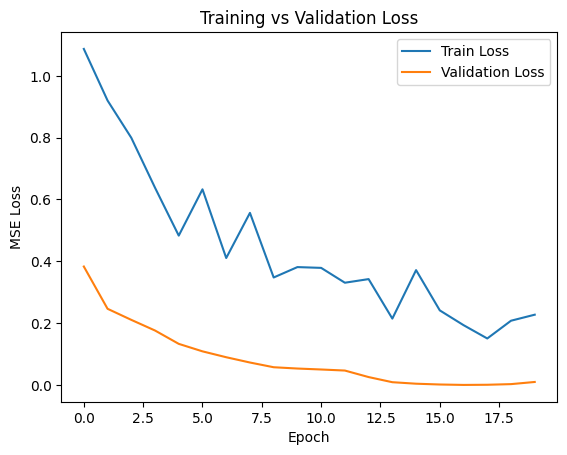

###**2. RMSE plot**

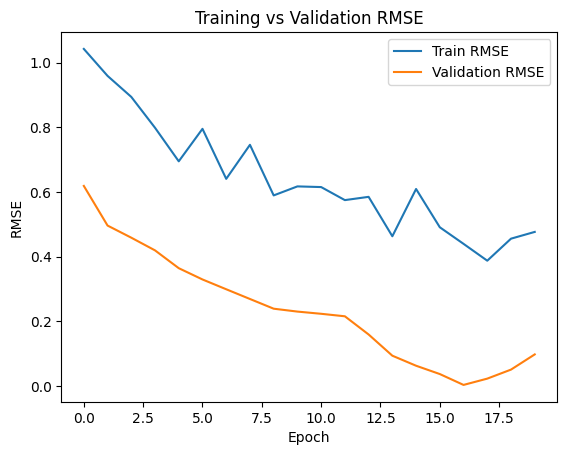

### **3. MAE PLOT**
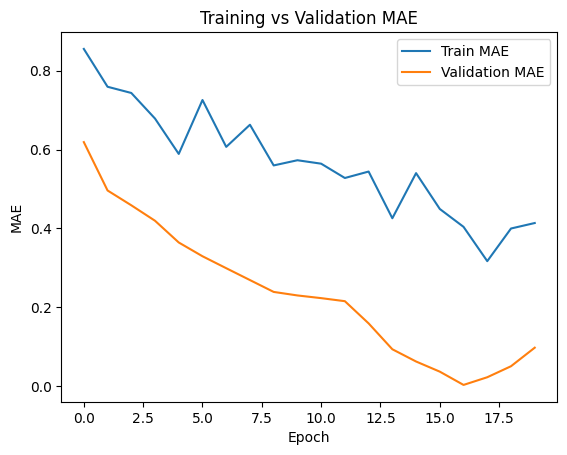


## **VII.ABLATION STUDIES**

In [ ]:
# ===============================
# Ablation logging containers
# ===============================

history = {
    "train_loss": [],
    "val_loss": [],
    "val_rmse": [],
    "val_rmse_stable": [],
    "val_rmse_volatile": [],
    "gate_mean": [],
    "mem_update_rate": []
}


### **1. Adaptive Forgetting (weight decay)**

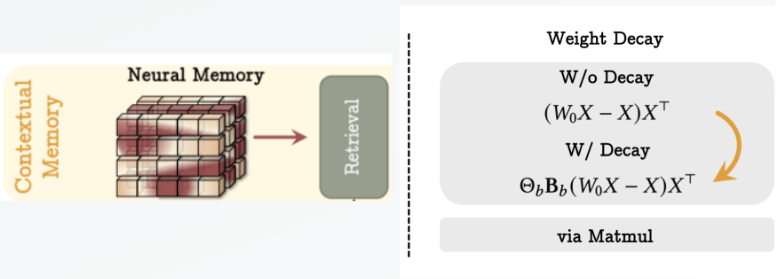

In [ ]:
model = MagTitan(
    input_dim=input_dim,
    model_dim=128,
    num_heads=4,
    chunk_size=1,
    memory_units=4,

    use_gating=True,
    use_surprise=True,
    use_adaptive_forgetting=False # Off
).to(device)

### **2. Surprise-driven Memory**

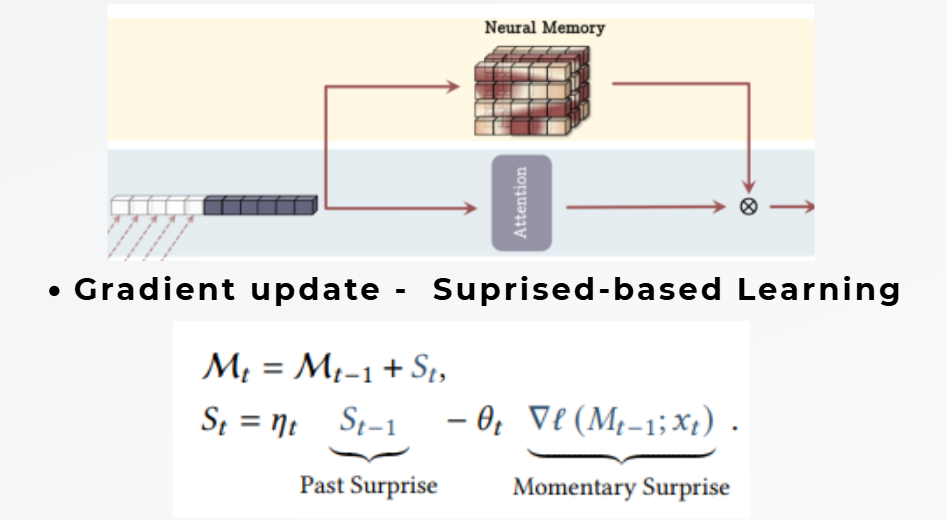

In [ ]:
model = MagTitan(
    input_dim=input_dim,
    model_dim=128,
    num_heads=4,
    chunk_size=1,
    memory_units=4,

    use_gating=True,
    use_surprise=False, # surprise OFF
    use_adaptive_forgetting=True
).to(device)

### **3. Memory Gating**

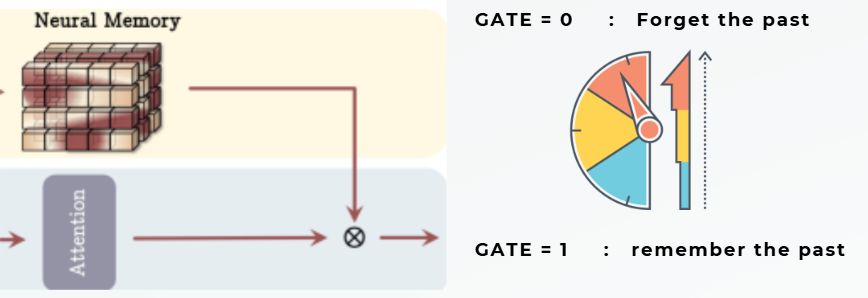

In [ ]:
model = MagTitan(
    input_dim=input_dim,
    model_dim=128,
    num_heads=4,
    chunk_size=1,
    memory_units=4,

    use_gating=False,   #gating OFF
    use_surprise=True,
    use_adaptive_forgetting=True
).to(device)

In [ ]:
for epoch in range(num_epochs):
    print(f"\n===== Epoch {epoch} / {num_epochs} =====")

    # ---------------------- TRAIN ----------------------
    model.train()

    train_loss = 0.0
    train_metrics_agg = {}   # global metrics

    gate_means = []
    mem_rates  = []

    prev_ticker = None
    for batch in train_loader:
        tkr = batch["ticker_id"][0].item()  # assumes batch is same ticker (true if dataset is ordered by ticker)
        if prev_ticker is None or tkr != prev_ticker:
            model.mem_state = None
            prev_ticker = tkr

        x = batch["x"].to(device)              # [B, T, F]
        y = batch["y"].to(device)              # [B]
        reg = batch["regime"].to(device)       # [B]

        optimizer.zero_grad()

        y_pred = model(x).squeeze(-1)          # [B]
        loss   = criterion(y_pred, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_loss += loss.item() * y.size(0)

        # naive forecast = last return in window (feature 0)
        naive = x[:, -1, 0]

        # global metrics
        update_metric_sums(y, y_pred, naive, train_metrics_agg, regime=None)

        # regime-specific metrics
        update_metric_sums(y, y_pred, naive, train_metrics_agg, regime=reg)

        # log gate + memory stats (only in training mode)
        if getattr(model, "last_gate_mean", None) is not None:
            gate_means.append(model.last_gate_mean)
        if getattr(model, "last_mem_update_rate", None) is not None:
            mem_rates.append(model.last_mem_update_rate)

    # epoch-level train stats
    train_loss /= len(train_dataset)
    train_metrics = compute_metrics(train_metrics_agg)

    avg_gate = float(np.mean(gate_means)) if gate_means else float("nan")
    avg_mem  = float(np.mean(mem_rates))  if mem_rates else float("nan")

    print(f"[Train] Loss: {train_loss:.6f}")
    for k, m in train_metrics.items():
        print(f"  {k}: RMSE={m['RMSE']:.5f}, MAE={m['MAE']:.5f}, MASE={m['MASE']:.5f}")
    print(f"  Gate mean (epoch): {avg_gate:.4f}")
    print(f"  Memory update rate (epoch): {avg_mem:.6f}")

    # ---------------------- VALIDATION ----------------------
    model.mem_state = None
    model.eval()

    val_loss = 0.0
    val_metrics_agg = {}

    with torch.no_grad():
        for batch in val_loader:
            model.mem_state = None
            x = batch["x"].to(device)
            y = batch["y"].to(device)
            reg = batch["regime"].to(device)

            y_pred = model(x).squeeze(-1)
            loss   = criterion(y_pred, y)
            val_loss += loss.item() * y.size(0)

            naive = x[:, -1, 0]

            # global + regime-specific metrics
            update_metric_sums(y, y_pred, naive, val_metrics_agg, regime=None)
            update_metric_sums(y, y_pred, naive, val_metrics_agg, regime=reg)

    val_loss /= len(val_dataset)
    val_metrics = compute_metrics(val_metrics_agg)

    print(f"[Val]   Loss: {val_loss:.6f}")
    for k, m in val_metrics.items():
        regime_name = {
            "global": "All",
            "reg_0": "Stable",
            "reg_1": "Volatile"
        }.get(k, k)
        print(f"  {regime_name}: RMSE={m['RMSE']:.5f}, MAE={m['MAE']:.5f}, MASE={m['MASE']:.5f}")
    # ===============================
    # STORE ABLATION METRICS
    # ===============================

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    # global RMSE
    history["val_rmse"].append(val_metrics["global"]["RMSE"])

    # regime-specific RMSE
    history["val_rmse_stable"].append(
        val_metrics.get("reg_0", {}).get("RMSE", np.nan)
    )
    history["val_rmse_volatile"].append(
        val_metrics.get("reg_1", {}).get("RMSE", np.nan)
    )

    history["gate_mean"].append(avg_gate)
    history["mem_update_rate"].append(avg_mem)

    # ---------------------- CHECKPOINT ----------------------
    ckpt_path = f"mag_titan_epoch{epoch:02d}.pt"
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_metrics": train_metrics,
        "val_metrics": val_metrics
    }, ckpt_path)

    print(f"Checkpoint saved → {ckpt_path}")

with open("history_THIS_RUN.pkl", "wb") as f:
    pickle.dump(history, f)


===== Epoch 0 / 20 =====
[Train] Loss: 0.755041
  global: RMSE=0.86893, MAE=0.75871, MASE=0.65149
  reg_0: RMSE=0.64974, MAE=0.54208, MASE=0.79766
  reg_1: RMSE=1.19197, MAE=1.19197, MASE=0.55842
  Gate mean (epoch): 0.1203
  Memory update rate (epoch): 0.867971
[Val]   Loss: 0.637586
  All: RMSE=0.79849, MAE=0.79849, MASE=0.38196
  Stable: RMSE=0.79849, MAE=0.79849, MASE=0.38196
Checkpoint saved → mag_titan_epoch00.pt

===== Epoch 1 / 20 =====
[Train] Loss: 0.779495
  global: RMSE=0.88289, MAE=0.76670, MASE=0.65836
  reg_0: RMSE=0.64424, MAE=0.53597, MASE=0.78867
  reg_1: RMSE=1.22817, MAE=1.22817, MASE=0.57538
  Gate mean (epoch): 0.1202
  Memory update rate (epoch): 0.994234
[Val]   Loss: 0.637586
  All: RMSE=0.79849, MAE=0.79849, MASE=0.38196
  Stable: RMSE=0.79849, MAE=0.79849, MASE=0.38196
Checkpoint saved → mag_titan_epoch01.pt

===== Epoch 2 / 20 =====
[Train] Loss: 0.791260
  global: RMSE=0.88953, MAE=0.77361, MASE=0.66429
  reg_0: RMSE=0.68560, MAE=0.56174, MASE=0.82659
  re

### **4. Plotting the Ablations**



In [ ]:
def load_history(path):
    with open(path, "rb") as f:
        return pickle.load(f)

def plot_ablation(hist_off, hist_on, title_suffix):
    epochs_on = np.arange(len(hist_on["val_rmse"]))
    epochs_off = np.arange(len(hist_off["val_rmse"])) # Generate epochs for hist_off

    # ------------------ GRAPH 1: VAL RMSE ------------------
    plt.figure()
    plt.plot(epochs_off, hist_off["val_rmse"], label="OFF", linestyle="--")
    plt.plot(epochs_on, hist_on["val_rmse"], label="ON", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Validation RMSE")
    plt.title(f"Validation RMSE vs Epoch ({title_suffix})")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ------------------ GRAPH 2: MEMORY UPDATE RATE ------------------
    plt.figure()
    plt.plot(epochs_off, hist_off["mem_update_rate"], label="OFF", linestyle="--")
    plt.plot(epochs_on, hist_on["mem_update_rate"], label="ON", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Memory Update Rate")
    plt.title(f"Memory Update Rate vs Epoch ({title_suffix})")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ------------------ GRAPH 3: GATE MEAN ------------------
    plt.figure()
    plt.plot(epochs_off, hist_off["gate_mean"], label="OFF", linestyle="--")
    plt.plot(epochs_on, hist_on["gate_mean"], label="ON", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Gate Mean")
    plt.title(f"Gate Activation vs Epoch ({title_suffix})")
    plt.legend()
    plt.grid(True)
    plt.show()

#### **A. Adaptive Forgetting ON/OFF**

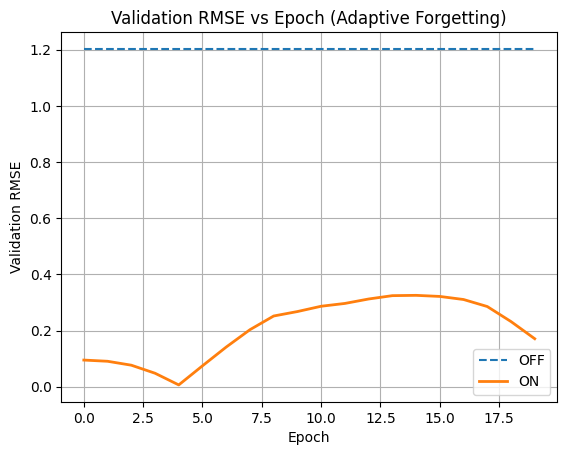

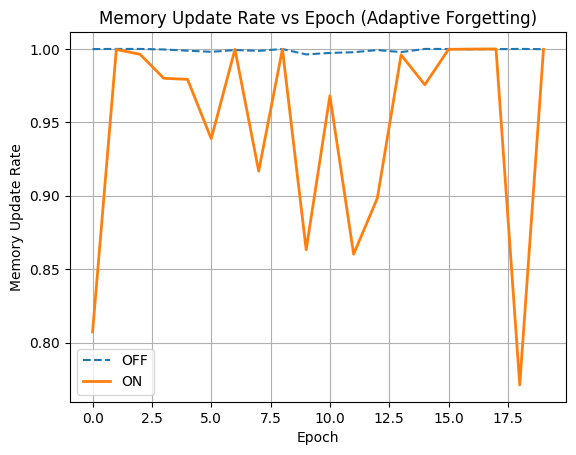

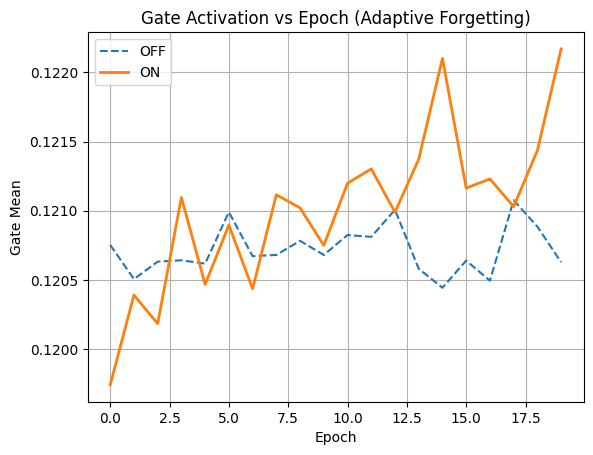

In [ ]:
hist_off = load_history("/content/AdapF_off.pkl")
hist_on  = load_history("/content/All-features-on.pkl")

plot_ablation(hist_off, hist_on, "Adaptive Forgetting")


#### **B. Surprise-driven Memory ON/OFF**

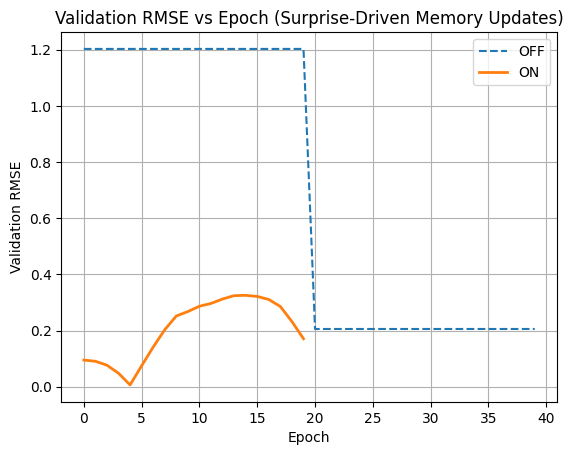

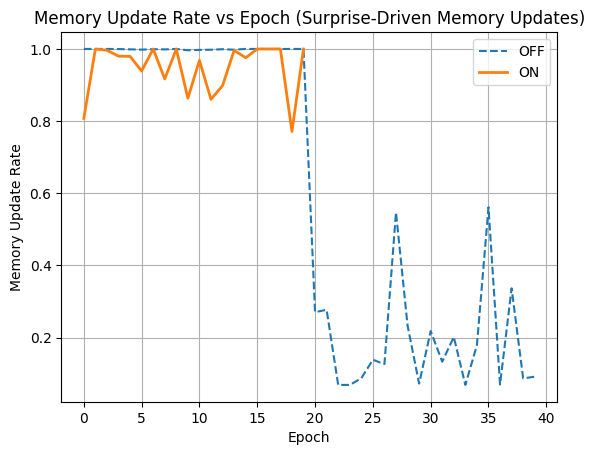

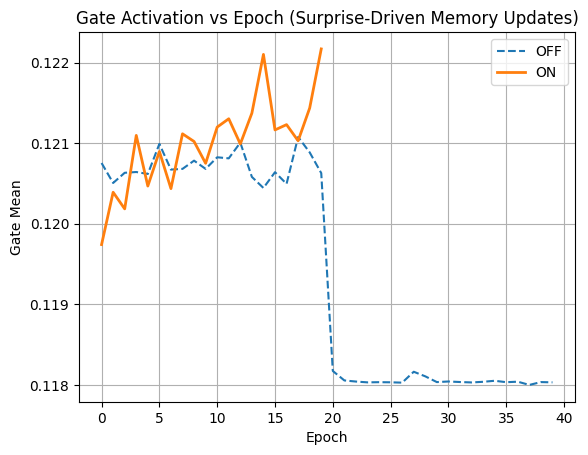

In [ ]:
hist_off = load_history("/content/Surprise_off.pkl")
hist_on  = load_history("/content/All-features-on.pkl")

plot_ablation(hist_off, hist_on, "Surprise-Driven Memory Updates")


#### **C. Memory Gating ON/OFF**

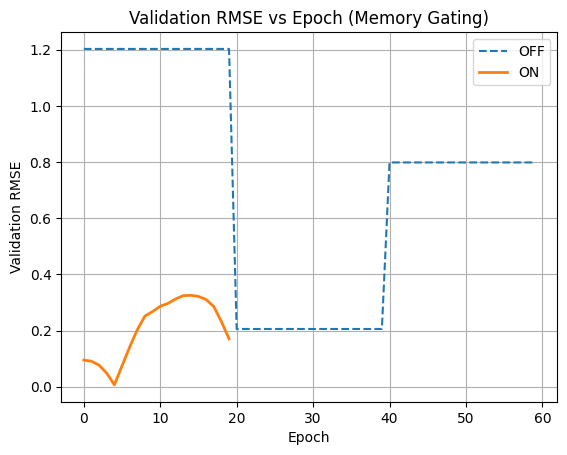

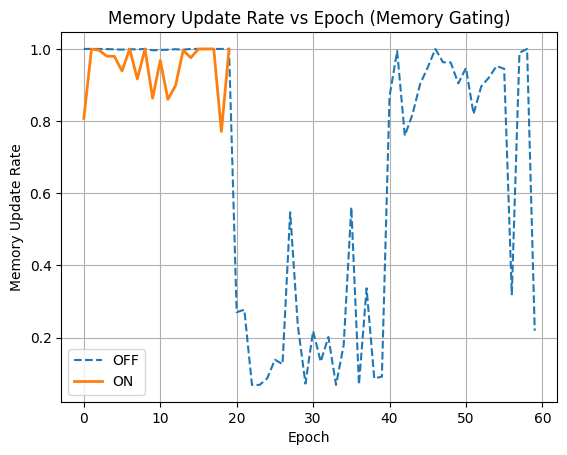

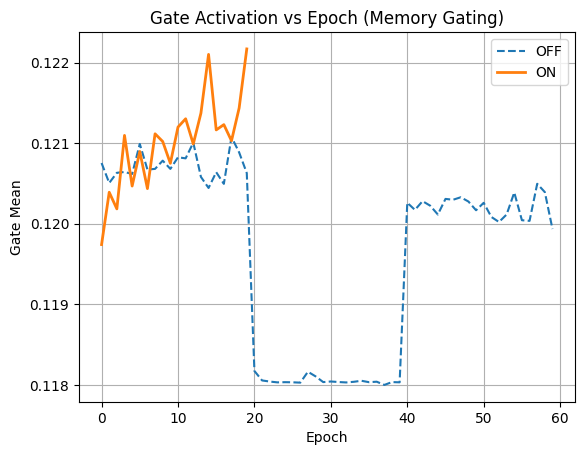

In [ ]:
hist_off = load_history("/content/gating_off.pkl")
hist_on  = load_history("/content/All-features-on.pkl")

plot_ablation(hist_off, hist_on, "Memory Gating")


#### **Debugging Trials documented**

**training loss didn't go down**

- We fixed:

  - input_dim msut match actual feature size

  - Changed learning rate and optimizers

  - temporarily removed memory (fused = core_out) → until attention learns →  then re-enable memory → Training improved

---

**When shapes / runtime errors appeared**

- we check

  - Batch size B vs Chunk size (they must be divisable B/chunk_size)

  - Feature dimension F vs input_dim

  - dim=-1 concatenation shapes: core_out and mem_out must be same [B,T,D]

  - match `input_dim` and `SEQ_LEN.`
  
  - Model was overfitting → we adjusted `model_dim=128` to `num_heads= 4`.

  - - indexing [:, -1, :] (last time step) - head output dimension = 1

---
**When gating didn't change**

- We inspected gate.mean() in stable vs volatile datasets → memory wasn't working → then adjusted:
  - memory units
  - model_dim






## **VIII. Resources**

-  Behrouz, A., Zhong, P., Li, Z., Kacham, P., Daliri, M., Deng, Y., Razaviyayn, M., & Mirrokni, V. (2024). Titans: Learning to Memorize at Test Time. arXiv.org Xu, W .,

-  lucidrains. (2025, November 28). GitHub - lucidrains/titans-pytorch: Unofficial implementation of Titans, https://github.com/lucidrains/titans-pytorch?tab=readme-ov-file#appreciation
‌
-  Dong, Z., Fan, X., & Peng, Z. (2024). FNSPID: A Comprehensive Financial News Dataset in Time Series arXiv+2

- ChaGPT. (2025 December 8). Sketching the model architecture, Debugging shape mismatches, Plotting tables and graphs RMSE, MSE, MAE based on training logs (O. AI, Ed.)

